# Experiment 02


The current approach for creating train, validation and test data sets is to split 
the data in long-format, i.e. one observation is an intensity value from one sample representing one peptide, into the desired splits. In this process missing values are not regarded.

- [x] mask entries in larger dataset in long-format
- [x] mask peptides based on their frequency in samples (probability of being observed)
- [x] create *long-format* training data set without masked values for each model
    - FNN based on embeddings of peptides and samples (long-format **without** missing values)
    - Denoising AE (wide-format **with** missing values)
    - VAE (wide-format **with** missing values)
- [ ] restrict to only a training data split of consective data: Increase number of samples.
    - focus on best reconstruction performance
    - mean comparison

### Collaborative Filtering model

- Cannot accomodate iid assumption of statistical test in current setup for embedding vectors.
  - if pretrained model should be applied to an new batch of replicates (with a certain condition) one would need to find a way to initialize the sample embeddings without fine-tuning the model

In [1]:
import logging
from pprint import pprint
import seaborn
import numpy.testing as npt  # fastcore.test functionality

from pathlib import Path


import vaep.io_images
from vaep.pandas import interpolate
from vaep.model import build_df_from_pred_batches

from src.nb_imports import *
from src import metadata
from src.logging import setup_logger

logger = setup_logger(logger=logging.getLogger('vaep'))
logger.info("Experiment 02")

figures = {}  # collection of ax or figures

FOLDER_MQ_TXT_DATA = data\mq_out
vaep - INFO     Experiment 02


In [2]:
# None takes all
N_SAMPLES: int = 1000
n_features: int = 50
ADD_TENSORBOARD: bool = False
FN_PEPTIDE_INTENSITIES: Path = (
    config.FOLDER_DATA / 'df_intensities_N07285_M01000')  # 90%
epochs_max = 10
batch_size = 32
latent_dim = 2
most_common: bool = False
most_uncommon: bool = False
out_folder: str = 'poster'
# write to read only config ? namedtuple?

In [3]:
# Parameters
n_feat = 400
n_epochs = 10
out_folder = "runs/2D"


In [4]:
BATCH_SIZE, EPOCHS = batch_size, epochs_max
folder = Path(out_folder) / f'feat_{n_features:04d}_epochs_{epochs_max:03d}'
print(f"{folder = }")

if most_common and most_uncommon:
    raise ValueError(f"Cannot be both True: {most_common = } and {most_uncommon = }")

folder = Path('runs/2D/feat_0050_epochs_010')


## Raw data

In [5]:
FN_PEPTIDE_INTENSITIES = Path(FN_PEPTIDE_INTENSITIES)

In [6]:
analysis = AnalyzePeptides(fname=FN_PEPTIDE_INTENSITIES, nrows=None)
analysis.df.columns.name = 'peptide'
analysis.log_transform(np.log2)
analysis

AnalyzePeptides with attributes: M, N, df, index_col, is_log_transformed, is_wide_format, log_fct, stats

In [7]:
# some date are not possible in the indices
rename_indices_w_wrong_dates = {'20161131_LUMOS1_nLC13_AH_MNT_HeLa_long_03': '20161130_LUMOS1_nLC13_AH_MNT_HeLa_long_03',
                                '20180230_QE10_nLC0_MR_QC_MNT_Hela_12': '20180330_QE10_nLC0_MR_QC_MNT_Hela_12',
                                '20161131_LUMOS1_nLC13_AH_MNT_HeLa_long_01': '20161130_LUMOS1_nLC13_AH_MNT_HeLa_long_01',
                                '20180230_QE10_nLC0_MR_QC_MNT_Hela_11': '20180330_QE10_nLC0_MR_QC_MNT_Hela_11',
                                '20161131_LUMOS1_nLC13_AH_MNT_HeLa_long_02': '20161130_LUMOS1_nLC13_AH_MNT_HeLa_long_02'}
analysis.df.rename(index=rename_indices_w_wrong_dates, inplace=True)

### Select N consecutive samples

In [8]:
analysis.get_consecutive_dates(n_samples=N_SAMPLES)

Get 1000 samples.
Training data referenced unter: df_1000
Updated attribute: df


peptide,AAAAAAALQAK,AAFDDAIAELDTLSEESYK,AAHSEGNTTAGLDMR,AAVATFLQSVQVPEFTPK,AAVEEGIVLGGGCALLR,AAVPSGASTGIYEALELR,AAVPSGASTGIYEALELRDNDK,ACANPAAGSVILLENLR,ACGLVASNLNLKPGECLR,ADLINNLGTIAK,...,VVFVFGPDK,VVFVFGPDKK,VYALPEDLVEVKPK,YADLTEDQLPSCESLK,YDDMAAAMK,YDDMAACMK,YDDMATCMK,YLAEVACGDDRK,YLDEDTIYHLQPSGR,YRVPDVLVADPPIAR
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,29.591,31.264,28.098,28.694,30.208,30.134,31.358,30.430,29.440,31.035,...,29.047,27.827,27.149,28.446,29.136,28.936,27.337,28.873,27.724,28.059
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,29.817,31.354,28.132,28.508,30.171,30.189,31.311,30.412,29.410,31.034,...,28.830,27.624,27.150,28.537,28.643,29.347,27.980,29.179,27.444,28.035
20181221_QE8_nLC0_NHS_MNT_HeLa_01,29.982,31.211,24.357,28.795,29.833,28.291,32.533,31.257,30.998,32.087,...,29.325,29.346,28.907,29.588,28.434,28.369,27.397,29.143,27.233,29.432
20181222_QE9_nLC9_QC_50CM_HeLa1,29.974,30.238,28.022,28.917,30.113,30.597,31.781,30.620,27.377,31.457,...,29.409,27.696,27.622,29.104,28.151,29.017,27.815,29.317,28.027,28.516
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,29.552,31.966,28.165,29.985,31.660,31.787,31.915,31.792,30.077,31.479,...,29.341,NaN,27.327,29.091,29.422,29.057,26.068,29.129,27.474,28.216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,31.517,32.278,30.832,31.541,32.803,33.676,31.927,31.906,27.631,33.747,...,31.452,28.512,29.634,31.134,30.690,30.142,29.881,31.508,29.884,29.468
20190805_QE1_nLC2_AB_MNT_HELA_01,31.104,31.747,28.999,28.458,30.588,28.800,32.415,31.270,30.077,32.357,...,29.504,29.435,28.424,29.489,29.702,29.877,28.777,30.471,27.793,29.185
20190805_QE1_nLC2_AB_MNT_HELA_02,31.248,31.923,28.643,28.257,31.068,28.864,32.340,31.672,31.636,32.466,...,29.728,29.741,28.667,29.647,29.555,29.709,28.592,30.776,27.955,29.272


In [9]:
assert not analysis.df._is_view

## Long format

- Data in long format: (peptide, sample_id, intensity)
- no missing values kept
- 

In [10]:
analysis.df_long.head()

intensity
Sample ID                           peptide                       
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAAAAAALQAK             29.591
                                    AAFDDAIAELDTLSEESYK     31.264
                                    AAHSEGNTTAGLDMR         28.098
                                    AAVATFLQSVQVPEFTPK      28.694
                                    AAVEEGIVLGGGCALLR       30.208

In [11]:
assert analysis.df_long.isna().sum().sum(
) == 0, "There are still missing values in the long format."

In [12]:
analysis.df_wide.head()

peptide,AAAAAAALQAK,AAFDDAIAELDTLSEESYK,AAHSEGNTTAGLDMR,AAVATFLQSVQVPEFTPK,AAVEEGIVLGGGCALLR,AAVPSGASTGIYEALELR,AAVPSGASTGIYEALELRDNDK,ACANPAAGSVILLENLR,ACGLVASNLNLKPGECLR,ADLINNLGTIAK,...,VVFVFGPDK,VVFVFGPDKK,VYALPEDLVEVKPK,YADLTEDQLPSCESLK,YDDMAAAMK,YDDMAACMK,YDDMATCMK,YLAEVACGDDRK,YLDEDTIYHLQPSGR,YRVPDVLVADPPIAR
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,29.591,31.264,28.098,28.694,30.208,30.134,31.358,30.430,29.440,31.035,...,29.047,27.827,27.149,28.446,29.136,28.936,27.337,28.873,27.724,28.059
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,29.817,31.354,28.132,28.508,30.171,30.189,31.311,30.412,29.410,31.034,...,28.830,27.624,27.150,28.537,28.643,29.347,27.980,29.179,27.444,28.035
20181221_QE8_nLC0_NHS_MNT_HeLa_01,29.982,31.211,24.357,28.795,29.833,28.291,32.533,31.257,30.998,32.087,...,29.325,29.346,28.907,29.588,28.434,28.369,27.397,29.143,27.233,29.432
20181222_QE9_nLC9_QC_50CM_HeLa1,29.974,30.238,28.022,28.917,30.113,30.597,31.781,30.620,27.377,31.457,...,29.409,27.696,27.622,29.104,28.151,29.017,27.815,29.317,28.027,28.516
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,29.552,31.966,28.165,29.985,31.660,31.787,31.915,31.792,30.077,31.479,...,29.341,NaN,27.327,29.091,29.422,29.057,26.068,29.129,27.474,28.216


In [13]:
assert analysis.df_wide.isna().sum().sum(
) > 0, "There are no missing values left in the wide format"

### Sampling peptides by their frequency (important for later)

- higher count, higher probability to be sampled into training data
- missing peptides are sampled both into training as well as into validation dataset
- everything not in training data is validation data

In [14]:
# freq_per_peptide = analysis.df.unstack().to_frame('intensity').reset_index(1, drop=True)
freq_per_peptide = analysis.df_long['intensity']
freq_per_peptide = freq_per_peptide.notna().groupby(level=1).sum()
print(f"{n_features = }")


n_features = 50


### Selecting N
 - most common
 - most uncommon

In [15]:
freq_per_pepitde = freq_per_peptide.sort_values(ascending=False)

if most_common:
    freq_per_pepitde = freq_per_pepitde.iloc[:n_features]
elif most_uncommon:
    freq_per_pepitde = freq_per_pepitde.iloc[-n_features:]
else:
    freq_per_pepitde = freq_per_pepitde.sample(n_features)
    
assert len(freq_per_pepitde.index) == n_features

freq_per_pepitde

peptide
DFTVSAMHGDMDQK                     997
LTGMAFR                            975
AAVPSGASTGIYEALELR                 955
TGVHHYSGNNIELGTACGK                998
FEDENFILK                          995
MDATANDVPSPYEVR                    998
TATESFASDPILYRPVAVALDTK            999
SEIDLFNIRK                         951
ELSDIAHR                           995
TTHFVEGGDAGNREDQINR                996
TYDATTHFETTCDDIK                   996
SNFAEALAAHK                        997
AHGPGLEGGLVGKPAEFTIDTK             964
ACANPAAGSVILLENLR                  957
GADFLVTEVENGGSLGSK                 997
LSVLGAITSVQQR                      959
FIIPQIVK                           995
IQLINNMLDK                         986
TLQIFNIEMK                         989
ATQALVLAPTR                        965
YTLPPGVDPTQVSSSLSPEGTLTVEAPMPK   1,000
VLITTDLLAR                         997
VNFAMNVGK                          987
TITLEVEPSDTIENVK                 1,000
FVPAEMGTHTVSVK                     992
TAFQEALDAAGDK    

In [16]:
analysis.df = analysis.df[freq_per_pepitde.index]
# ToDo: clean-up other attributes needs to be integrated
del analysis._df_long  # , analysis._df_wide
analysis.df_long

intensity
Sample ID                           peptide                       
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 DFTVSAMHGDMDQK          28.586
                                    LTGMAFR                 31.017
                                    AAVPSGASTGIYEALELR      30.134
                                    TGVHHYSGNNIELGTACGK     29.271
                                    FEDENFILK               31.761
...                                                            ...
20190805_QE1_nLC2_AB_MNT_HELA_04    ATAVVDGAFK              30.326
                                    LMDVGLIAIR              29.522
                                    ILDQGEDFPASEMTR         26.447
                                    TATPQQAQEVHEK           32.062
                                    ETNLDSLPLVDTHSK         28.479

[49296 rows x 1 columns]

- biological stock differences in PCA plot. Show differences in models. Only see biological variance

## PCA plot of raw data

vaep - ERROR    Could not find LC instrument in 20190418_QX8_JuSc_MA_HeLa_500ng_1


vaep - ERROR    Could not find LC instrument in 20190422_QX8_JuSc_MA_HeLa_500ng_1


vaep - ERROR    Could not find LC instrument in 20190425_QX8_JuSc_MA_HeLa_500ng_1


vaep - ERROR    Could not find LC instrument in 20190501_QX8_MiWi_MA_HeLa_500ng_new


vaep - ERROR    Could not find LC instrument in 20190502_QX7_ChDe_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190502_QX8_MiWi_MA_HeLa_500ng_new


vaep - ERROR    Could not find LC instrument in 20190502_QX8_MiWi_MA_HeLa_500ng_old


vaep - ERROR    Could not find LC instrument in 20190506_QX7_ChDe_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190506_QX8_MiWi_MA_HeLa_500ng_new


vaep - ERROR    Could not find LC instrument in 20190506_QX8_MiWi_MA_HeLa_500ng_old


vaep - ERROR    Could not find LC instrument in 20190514_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190520_QX4_JoSw_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190521_QX4_JoSw_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190524_QX4_JoSw_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190526_QX4_LiSc_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190527_QX4_IgPa_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190530_QX4_IgPa_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190603_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190606_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190607_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190611_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190615_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190617_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190617_QX8_IgPa_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190618_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190618_QX4_JiYu_MA_HeLa_500ng_190618125902


vaep - ERROR    Could not find LC instrument in 20190618_QX4_JiYu_MA_HeLa_500ng_190619010035


vaep - ERROR    Could not find LC instrument in 20190618_QX4_JiYu_MA_HeLa_500ng_centroid


vaep - ERROR    Could not find LC instrument in 20190621_QX4_JoMu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190621_QX4_JoMu_MA_HeLa_500ng_190621161214


vaep - ERROR    Could not find LC instrument in 20190624_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190629_QX4_JiYu_MA_HeLa_500ng_MAX_ALLOWED


vaep - ERROR    Could not find LC instrument in 20190701_QX4_MePh_MA_HeLa_500ng_MAX_ALLOWED


vaep - ERROR    Could not find LC instrument in 20190703_QX4_MaTa_MA_HeLa_500ng_MAX_ALLOWED


vaep - ERROR    Could not find LC instrument in 20190706_QX4_MiWi_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190706_QX4_MiWi_MA_HeLa_500ng_190707003046


vaep - ERROR    Could not find LC instrument in 20190717_QX8_ChSc_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190718_QX8_ChSc_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190719_QX8_ChSc_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190722_QX4_StEb_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190722_QX8_ChSc_MA_HeLa_500ng_190722174431


vaep - ERROR    Could not find LC instrument in 20190725_QX2_MePh_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190726_QX8_ChSc_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190731_QX8_ChSc_MA_HeLa_500ng


Created metadata DataFrame attribute `df_meta`.
Added proportion of not NA values based on `df` intensities.


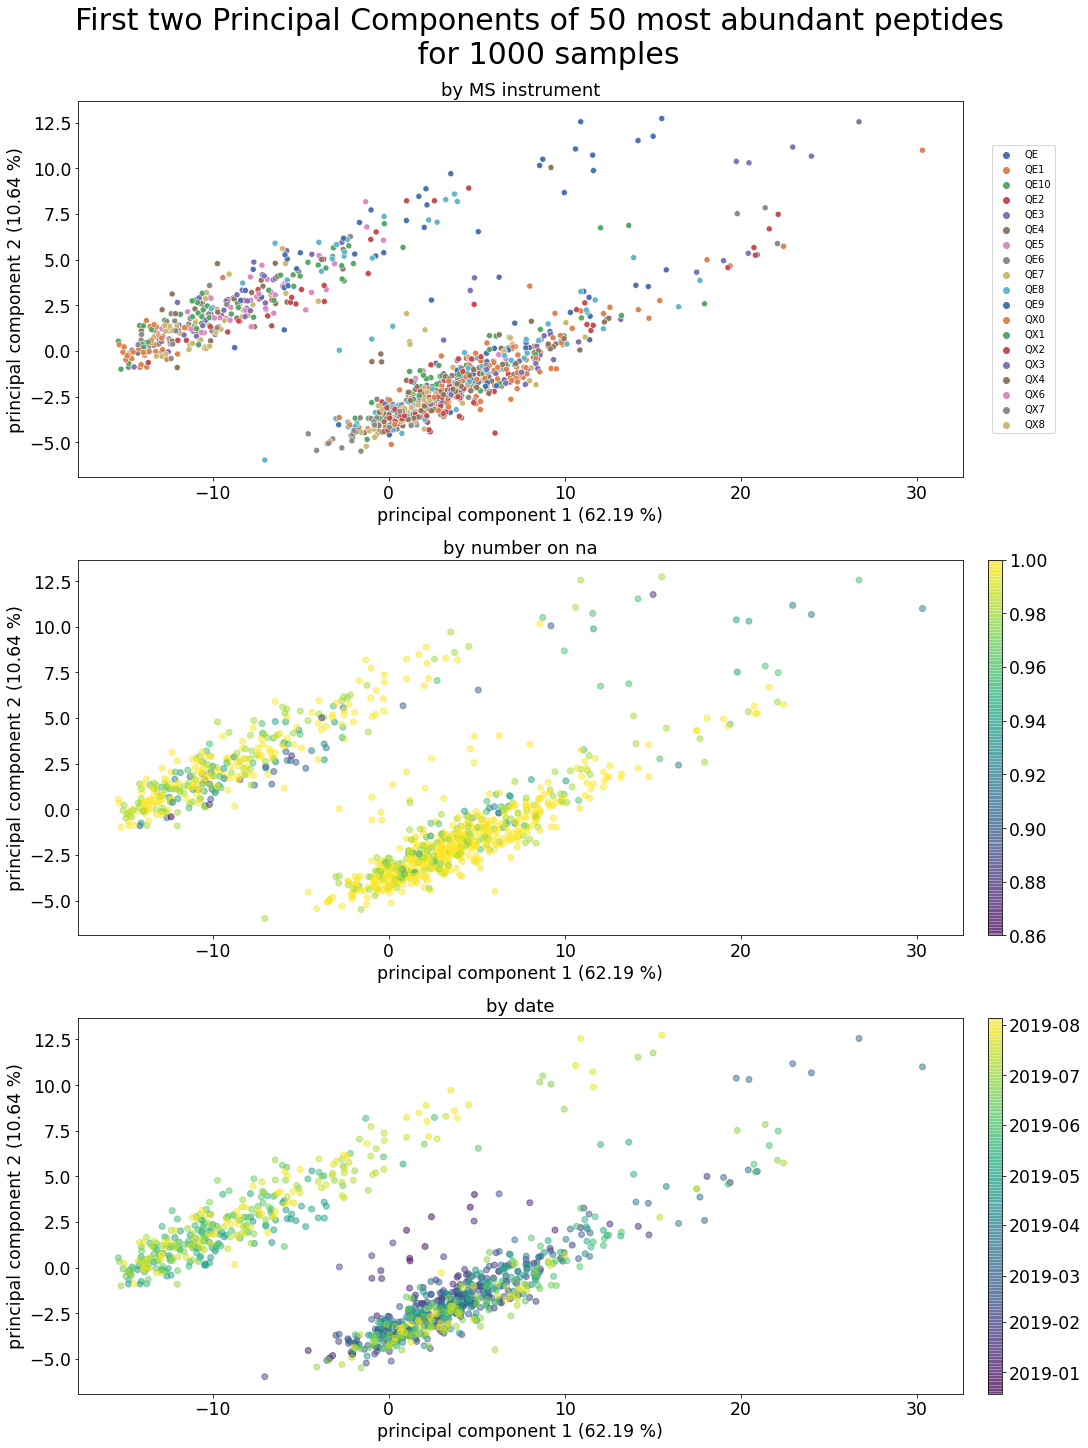

In [17]:
fig = analysis.plot_pca()

In [18]:
# ToDo add df_meta property
analysis.df_meta.describe()

,prop_not_na
count,"1,000.000"
mean,0.986
std,0.024
min,0.860
25%,0.980
50%,1.000
75%,1.000
max,1.000


In [19]:
vaep.io_images._savefig(fig, folder /
                        f'pca_plot_raw_data_{analysis.fname_stub}')

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\pca_plot_raw_data_N01000_M00050


## Train and Validation data

- use mulitindex for obtaining validation split

In [20]:
# analysis._df_long = analysis.df_long.reset_index(
# ).set_index(['Sample ID', 'peptide'])
analysis.df_long

intensity
Sample ID                           peptide                       
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 DFTVSAMHGDMDQK          28.586
                                    LTGMAFR                 31.017
                                    AAVPSGASTGIYEALELR      30.134
                                    TGVHHYSGNNIELGTACGK     29.271
                                    FEDENFILK               31.761
...                                                            ...
20190805_QE1_nLC2_AB_MNT_HELA_04    ATAVVDGAFK              30.326
                                    LMDVGLIAIR              29.522
                                    ILDQGEDFPASEMTR         26.447
                                    TATPQQAQEVHEK           32.062
                                    ETNLDSLPLVDTHSK         28.479

[49296 rows x 1 columns]

In [21]:
# df_long = analysis.df.unstack().to_frame('intensity').reset_index(1)
analysis.df_train = analysis.df_long.reset_index(0).groupby(
    by='Sample ID',
    level=0
).sample(frac=0.90,
         weights=freq_per_peptide,
         random_state=42)
analysis.df_train = analysis.df_train.reset_index().set_index([
    'Sample ID', 'peptide'])
analysis.df_train

,,intensity
Sample ID,peptide,
20190415_QE10_nLC9_LiNi_QC_45cm_HeLa_02,AAVPSGASTGIYEALELR,29.747
20190730_QE1_nLC2_GP_MNT_HELA_02,AAVPSGASTGIYEALELR,29.046
20190625_QE2_NLC1_GP_QC_MNT_HELA_01,AAVPSGASTGIYEALELR,28.139
20190528_QX8_MiWi_MA_HeLa_BR14_500ng,AAVPSGASTGIYEALELR,34.117
20190208_QE2_NLC1_AB_QC_MNT_HELA_4,AAVPSGASTGIYEALELR,29.334
...,...,...
20190426_QX1_JoMu_MA_HeLa_500ng_LC11,YTLPPGVDPTQVSSSLSPEGTLTVEAPMPK,32.196
20190715_QE2_NLC1_ANHO_MNT_HELA_03,YTLPPGVDPTQVSSSLSPEGTLTVEAPMPK,28.914
20190513_QE6_LC4_IAH_QC_MNT_HeLa_01,YTLPPGVDPTQVSSSLSPEGTLTVEAPMPK,29.678


In [22]:
analysis.indices_valid = analysis.df_long.index.difference(
    analysis.df_train.index)
analysis.df_valid = analysis.df_long.loc[analysis.indices_valid]

In [23]:
assert len(analysis.df_long) == len(analysis.df_train) + len(analysis.df_valid)

Check that all samples are also in the validation data

In [24]:
assert analysis.df_train.index.levshape == (N_SAMPLES, n_features)

try:
    assert analysis.df_valid.index.levshape == (N_SAMPLES, n_features)
except AssertionError:
    print(f'Expected shape in validation: {(N_SAMPLES, n_features)}')
    print(f'Shape in validation: {analysis.df_valid.index.levshape}')

analysis.df_train = analysis.df_train.loc[analysis.df_valid.index.levels[0]]
analysis.df_train = analysis.df_train.reset_index().set_index(
    ['Sample ID', 'peptide'])  # update index categories (there is probably a better way)
N_SAMPLES = analysis.df_valid.index.levshape[0]
analysis.df_train.index.levshape, analysis.df_valid.index.levshape

Expected shape in validation: (1000, 50)
Shape in validation: (995, 50)


((995, 50), (995, 50))

## Setup DL

- [ ] move all above to separate data notebook

In [25]:
import vaep.models as models
from vaep.models.cmd import get_args
from vaep.models import ae

args = get_args(batch_size=BATCH_SIZE, epochs=EPOCHS,
                no_cuda=False)  # data transfer to GPU seems slow
kwargs = {'num_workers': 2, 'pin_memory': True} if args.cuda else {}

# torch.manual_seed(args.seed)
device = torch.device("cuda" if args.cuda else "cpu")
device

print(f"{args = }", f"{device = }", sep='\n')

args = Namespace(batch_size=32, cuda=True, epochs=10, log_interval=10, no_cuda=False, seed=43)
device = device(type='cuda')


Fastai default device for computation

In [26]:
import fastai.torch_core
print(f"{torch.cuda.is_available() = }")  # self-documenting python 3.8
fastai.torch_core.defaults

torch.cuda.is_available() = True


namespace(cpus=12,
          use_cuda=None,
          activation=torch.nn.modules.activation.ReLU,
          callbacks=[fastai.callback.core.TrainEvalCallback,
                     fastai.learner.Recorder,
                     fastai.callback.progress.ProgressCallback],
          lr=0.001)

### Comparison data

- first impute first and last row (using n=3 replicate)
- use pandas interpolate

In [27]:
analysis.median_train = analysis.df_train['intensity'].unstack().median()
analysis.median_train.name = 'train_median'
analysis.averag_train = analysis.df_train['intensity'].unstack().mean()
analysis.averag_train.name = 'train_average'

df_pred = analysis.df_valid.copy()

df_pred = df_pred.join(analysis.median_train, on='peptide')
df_pred = df_pred.join(analysis.averag_train, on='peptide')


_ = interpolate(wide_df=analysis.df_train['intensity'].unstack())
df_pred = df_pred.join(_)

df_pred

intensity  \
Sample ID                            peptide                         
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AAVPSGASTGIYEALELR     30.134   
                                     ATAVVDGAFK             29.988   
                                     ETNLDSLPLVDTHSK        29.572   
                                     TLQIFNIEMK             27.540   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ACANPAAGSVILLENLR      30.412   
...                                                            ...   
20190805_QE1_nLC2_AB_MNT_HELA_04     ELSDIAHR               31.582   
                                     HLPTLDHPIIPADYVAIK     27.738   
                                     IAGYVTHLMK             30.712   
                                     LMDVGLIAIR             29.522   
                                     SSILLDVKPWDDETDMAK     30.523   

                                                         train_median  \
Sample ID                            peptide                            
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AAVPSGASTGIYEALELR        29.355   
                                     ATAVVDGAFK                30.200   
                                     ETNLDSLPLVDTHSK           29.123   
                                     TLQIFNIEMK                28.825   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ACANPAAGSVILLENLR         31.210   
...                                                               ...   
20190805_QE1_nLC2_AB_MNT_HELA_04     ELSDIAHR                  31.429   
                                     HLPTLDHPIIPADYVAIK        29.776   
                                     IAGYVTHLMK                30.491   
                                     LMDVGLIAIR                29.438   
                                     SSILLDVKPWDDETDMAK        30.107   

                                                         train_average  \
Sample ID                            peptide                             
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AAVPSGASTGIYEALELR         30.376   
                                     ATAVVDGAFK                 30.004   
                                     ETNLDSLPLVDTHSK            29.743   
                                     TLQIFNIEMK                 28.591   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ACANPAAGSVILLENLR          31.017   
...                                                                ...   
20190805_QE1_nLC2_AB_MNT_HELA_04     ELSDIAHR                   31.309   
                                     HLPTLDHPIIPADYVAIK         30.108   
                                     IAGYVTHLMK                 30.395   
                                     LMDVGLIAIR                 29.526   
                                     SSILLDVKPWDDETDMAK         29.931   

                                                         replicates  
Sample ID                            peptide                         
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AAVPSGASTGIYEALELR      30.189  
                                     ATAVVDGAFK              30.017  
                                     ETNLDSLPLVDTHSK         29.458  
                                     TLQIFNIEMK              27.546  
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ACANPAAGSVILLENLR       30.844  
...                                                             ...  
20190805_QE1_nLC2_AB_MNT_HELA_04     ELSDIAHR                31.294  
                                     HLPTLDHPIIPADYVAIK      27.612  
                                     IAGYVTHLMK              31.195  
                                     LMDVGLIAIR              27.558  
                                     SSILLDVKPWDDETDMAK      28.145  

[4928 rows x 4 columns]

In [28]:
if any(df_pred.isna()):
    print("Consecutive NaNs are not imputed using replicates.")
    display(df_pred.loc[df_pred.isna().any(axis=1)])

Consecutive NaNs are not imputed using replicates.


,,intensity,train_median,train_average,replicates
Sample ID,peptide,,,,
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,ATAVVDGAFK,30.067,30.200,30.004,NaN
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_03,LALVTGGEIASTFDHPELVK,30.674,30.482,30.409,NaN
20181228_QE6_nLC6_CSC_QC_MNT_HeLa_01,FIIPQIVK,32.131,31.775,31.722,NaN
20190111_QE2_NLC10_ANHO_QC_MNT_HELA_02,FVPAEMGTHTVSVK,31.047,30.146,29.735,NaN
20190114_QE4_LC6_IAH_QC_MNT_HeLa_250ng_01,LNSVQSSERPLFLVHPIEGSTTVFHSLASR,31.253,30.577,30.381,NaN
...,...,...,...,...,...
20190718_QE8_nLC14_RG_QC_HeLa_MUC_50cm_1,AQLLQPTLEINPR,28.579,28.363,28.551,NaN
20190722_QX8_ChSc_MA_HeLa_500ng_190722174431,LALVTGGEIASTFDHPELVK,32.400,30.482,30.409,NaN
20190723_QX1_JoMu_MA_HeLa_500ng_LC10_pack-2000bar,AAVPSGASTGIYEALELR,34.012,29.355,30.376,NaN


## Collaboritive filtering model

In [29]:
from fastai.collab import CollabDataLoaders, MSELossFlat, Learner
from fastai.collab import EmbeddingDotBias

analysis.collab = Analysis()
collab = analysis.collab
collab.columns = 'peptide,Sample ID,intensity'.split(',')

Create data view for collaborative filtering

- currently a bit hacky as the splitter does not support predefinded indices (create custum subclass providing splits to internal methods?)

- Use the [`CollabDataLoaders`](https://docs.fast.ai/collab.html#CollabDataLoaders)  similar to the [`TabularDataLoaders`](https://docs.fast.ai/tabular.data.html#TabularDataLoaders).
- Use the [`IndexSplitter`](https://docs.fast.ai/data.transforms.html#IndexSplitter) and provide splits to whatever is used in `CollabDataLoaders`


In [30]:
collab.df_train = analysis.df_train.reset_index()
collab.df_valid = analysis.df_valid.reset_index()
collab.df_train.head()

,Sample ID,peptide,intensity
0,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,ACANPAAGSVILLENLR,30.430
1,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,AHGPGLEGGLVGKPAEFTIDTK,27.649
2,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,AQLLQPTLEINPR,27.275
3,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,ATQALVLAPTR,29.220
4,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,DFTVSAMHGDMDQK,28.586


In [31]:
collab.df_valid.head()

,Sample ID,peptide,intensity
0,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,AAVPSGASTGIYEALELR,30.134
1,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,ATAVVDGAFK,29.988
2,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,ETNLDSLPLVDTHSK,29.572
3,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,TLQIFNIEMK,27.540
4,20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,ACANPAAGSVILLENLR,30.412


In [32]:
assert (collab.df_train.intensity.isna().sum(),
        collab.df_valid.intensity.isna().sum()) == (0, 0), "Remove missing values."

Hacky part uses training data `Datasets` from dataloaders to recreate a custom `DataLoaders` instance

In [33]:
collab.dl_train = CollabDataLoaders.from_df(
    collab.df_train, valid_pct=0.0, user_name='Sample ID', item_name='peptide', rating_name='intensity', bs=args.batch_size, device=device)
collab.dl_valid = CollabDataLoaders.from_df(
    collab.df_valid, valid_pct=0.0, user_name='Sample ID', item_name='peptide', rating_name='intensity', bs=args.batch_size,
    shuffle=False, device=device)
collab.dl_train.show_batch()

,Sample ID,peptide,intensity
0,20190510_QE1_nLC2_ANHO_QC_MNT_HELA_07,FVPAEMGTHTVSVK,31.550
1,20190204_QE2_NLC10_ANHO_QC_MNT_HELA_02,TLQIFNIEMK,29.439
2,20190625_QX7_IgPa_MA_HeLa_Br14_500ng,LGGSAVISLEGKPL,32.048
3,20190606_QE4_LC12_JE_QC_MNT_HeLa_02,NTGIICTIGPASR,31.064
4,20190429_QX0_ChDe_MA_HeLa_500ng_LC07_1_BR13_190507121913,SSILLDVKPWDDETDMAK,31.890
5,20190731_QX2_IgPa_MA_HeLa_500ng_CTCDoff_LC05,TATPQQAQEVHEK,33.247
6,20190621_QE1_nLC2_ANHO_QC_MNT_HELA_03,ELSDIAHR,31.028
7,20190411_QE3_nLC5_DS_QC_MNT_HeLa_01,NTGIICTIGPASR,31.296
8,20190725_QE9_nLC9_RG_QC_MNT_HeLa_MUC_50cm_1,VLITTDLLAR,28.087
9,20190104_QE6_nLC6_MM_QC_MNT_HELA_02_190107214303,VNFAMNVGK,29.516


In [34]:
from fastai.data.core import DataLoaders
collab.dls = DataLoaders(collab.dl_train.train, collab.dl_valid.train)
if args.cuda:
    collab.dls.cuda()

In [35]:
collab.dl_valid.show_batch()

,Sample ID,peptide,intensity
0,20190604_QX8_MiWi_MA_HeLa_BR14_500ng,TGVHHYSGNNIELGTACGK,31.261
1,20190204_QE6_nLC6_MPL_QC_MNT_HeLa_02,SSILLDVKPWDDETDMAK,30.419
2,20190415_QE10_nLC9_LiNi_QC_45cm_HeLa_02,LTGMAFR,29.840
3,20190111_QE8_nLC1_ASD_QC_HeLa_02,DFTVSAMHGDMDQK,29.884
4,20190716_QE8_nLC14_RG_QC_MNT_HeLa_MUC_50cm_2,KFDQLLAEEK,28.047
5,20190404_QE7_nLC3_AL_QC_MNT_HeLa_02,DFTVSAMHGDMDQK,28.989
6,20190204_QE1_nLC2_GP_QC_MNT_HELA_01,VLITTDLLAR,29.661
7,20190220_QE3_nLC7_TSB_QC_MNT_HELA_02,LMDVGLIAIR,25.651
8,20190521_QE7_nLC5_TSB_QC_MNT_HeLa_01,SEIDLFNIRK,31.161
9,20190509_QX6_ChDe_MA_HeLa_Br14_500ng_LC09_20190509120700,LNSVQSSERPLFLVHPIEGSTTVFHSLASR,30.473


In [36]:
len(collab.dls.classes['Sample ID']), len(collab.dls.classes['peptide'])

(996, 51)

In [37]:
len(collab.dls.train), len(collab.dls.valid)  # mini-batches

(1378, 154)

Alternatively to the hacky version, one could use a factory method, but there the sampling/Splitting methods would need to be implemented (not using [`RandomSplitter`](https://docs.fast.ai/data.transforms.html#RandomSplitter) somehow)

 - [`TabDataLoader`](https://docs.fast.ai/tabular.core.html#TabDataLoader)
 - uses [`TabularPandas`](https://docs.fast.ai/tabular.core.html#TabularPandas)
 
 > Current problem: No custom splitter can be provided

### Model

In [38]:
collab.model_args = {}
collab.model_args['n_samples'] = len(collab.dls.classes['Sample ID'])
collab.model_args['n_peptides'] = len(collab.dls.classes['peptide'])
collab.model_args['dim_latent_factors'] = latent_dim
collab.model_args['y_range'] = (
    int(analysis.df_train['intensity'].min()), int(analysis.df_train['intensity'].max())+1)

print("Args:")
pprint(collab.model_args)


# from vaep.models.collab import DotProductBias
# model = DotProductBias(**collab.model_args)
model = EmbeddingDotBias.from_classes(
    n_factors=collab.model_args['dim_latent_factors'], classes=collab.dls.classes, y_range=collab.model_args['y_range'])
learn = Learner(dls=collab.dls, model=model, loss_func=MSELossFlat())
if args.cuda:
    learn.cuda()
learn.summary()

Args:
{'dim_latent_factors': 2,
 'n_peptides': 51,
 'n_samples': 996,
 'y_range': (20, 36)}


EmbeddingDotBias (Input shape: 32 x 2)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 2              
Embedding                                 1992       True      
Embedding                                 102        True      
____________________________________________________________________________
                     32 x 1              
Embedding                                 996        True      
Embedding                                 51         True      
____________________________________________________________________________

Total params: 3,141
Total trainable params: 3,141
Total non-trainable params: 0

Optimizer used: <function Adam at 0x00000198F1837040>
Loss function: FlattenedLoss of MSELoss()

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

### Training

In [39]:
learn.fit_one_cycle(epochs_max, 5e-3)

epoch,train_loss,valid_loss,time
0,1.981202,1.803697,00:07
1,0.786131,0.760438,00:08
2,0.638046,0.632467,00:08
3,0.633735,0.598015,00:08
4,0.506649,0.586428,00:08
5,0.510225,0.570241,00:08
6,0.612370,0.558717,00:08
7,0.496692,0.553455,00:08
8,0.523756,0.551424,00:08
9,0.484973,0.550786,00:08


vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\collab_training


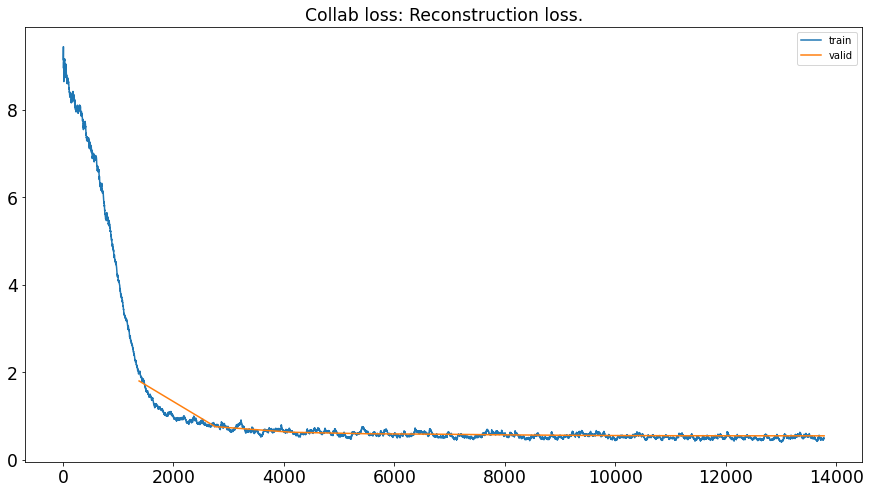

In [40]:
from vaep.models import plot_loss
from fastai import learner
learner.Recorder.plot_loss = plot_loss

fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title('Collab loss: Reconstruction loss.')
learn.recorder.plot_loss(skip_start=5, ax=ax)
vaep.io_images._savefig(fig, name='collab_training',
                        folder=folder)

### Evaluation

In [41]:
collab.dls.valid_ds.items

,Sample ID,peptide,intensity
"3,085",629,40,31.261
621,125,35,30.419
"1,926",382,29,29.840
210,45,7,29.884
"4,291",871,22,28.047
...,...,...,...
"2,134",425,6,31.057
"4,509",913,43,28.322
"2,685",544,1,28.728
"1,995",393,10,30.882


In [42]:
df_pred = df_pred.reset_index()
pred, target = learn.get_preds()
df_pred['intensity_pred_collab'] = pd.Series(
    pred.flatten().numpy(), index=collab.dls.valid.items.index)

npt.assert_almost_equal(
    actual=collab.dls.valid.items.intensity.to_numpy(),
    desired=target.numpy().flatten()
)


df_pred = analyzers.cast_object_to_category(df_pred)
df_pred.set_index(['Sample ID', 'peptide'], inplace=True)
df_pred

intensity  \
Sample ID                            peptide                         
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AAVPSGASTGIYEALELR     30.134   
                                     ATAVVDGAFK             29.988   
                                     ETNLDSLPLVDTHSK        29.572   
                                     TLQIFNIEMK             27.540   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ACANPAAGSVILLENLR      30.412   
...                                                            ...   
20190805_QE1_nLC2_AB_MNT_HELA_04     ELSDIAHR               31.582   
                                     HLPTLDHPIIPADYVAIK     27.738   
                                     IAGYVTHLMK             30.712   
                                     LMDVGLIAIR             29.522   
                                     SSILLDVKPWDDETDMAK     30.523   

                                                         train_median  \
Sample ID                            peptide                            
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AAVPSGASTGIYEALELR        29.355   
                                     ATAVVDGAFK                30.200   
                                     ETNLDSLPLVDTHSK           29.123   
                                     TLQIFNIEMK                28.825   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ACANPAAGSVILLENLR         31.210   
...                                                               ...   
20190805_QE1_nLC2_AB_MNT_HELA_04     ELSDIAHR                  31.429   
                                     HLPTLDHPIIPADYVAIK        29.776   
                                     IAGYVTHLMK                30.491   
                                     LMDVGLIAIR                29.438   
                                     SSILLDVKPWDDETDMAK        30.107   

                                                         train_average  \
Sample ID                            peptide                             
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AAVPSGASTGIYEALELR         30.376   
                                     ATAVVDGAFK                 30.004   
                                     ETNLDSLPLVDTHSK            29.743   
                                     TLQIFNIEMK                 28.591   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ACANPAAGSVILLENLR          31.017   
...                                                                ...   
20190805_QE1_nLC2_AB_MNT_HELA_04     ELSDIAHR                   31.309   
                                     HLPTLDHPIIPADYVAIK         30.108   
                                     IAGYVTHLMK                 30.395   
                                     LMDVGLIAIR                 29.526   
                                     SSILLDVKPWDDETDMAK         29.931   

                                                         replicates  \
Sample ID                            peptide                          
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AAVPSGASTGIYEALELR      30.189   
                                     ATAVVDGAFK              30.017   
                                     ETNLDSLPLVDTHSK         29.458   
                                     TLQIFNIEMK              27.546   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ACANPAAGSVILLENLR       30.844   
...                                                             ...   
20190805_QE1_nLC2_AB_MNT_HELA_04     ELSDIAHR                31.294   
                                     HLPTLDHPIIPADYVAIK      27.612   
                                     IAGYVTHLMK              31.195   
                                     LMDVGLIAIR              27.558   
                                     SSILLDVKPWDDETDMAK      28.145   

                                                         intensity_pred_collab  
Sample ID                            peptide                                    
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AAVPSGASTGIYEALELR                 29.939  
                                     ATAVVDGAFK                   

In [43]:
assert (abs(target.reshape(-1) - pred.reshape(-1))).sum() / len(target) - \
    (df_pred.intensity - df_pred.intensity_pred_collab).abs().sum() / \
    len(df_pred) < 0.00001

### Plot biases and embedding weigths

- visualize relative order of samples and peptides

In [44]:
from collections import namedtuple
def get_bias(learner, indices, is_item=True) -> pd.Series:
    ret = learner.model.bias(indices.values, is_item=is_item) # user=sample
    return pd.Series(ret, index=indices)

# def get_weigths

CollabIDs = namedtuple("CollabIDs", "sample peptide")

collab.biases = CollabIDs(
    sample=get_bias(learn, indices=analysis.df_train.index.levels[0], is_item=False), # item=peptide
    peptide=get_bias(learn, indices=analysis.df_train.index.levels[1] )
)
collab.biases.sample.head()

Sample ID
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02     0.075
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01    0.123
20181221_QE8_nLC0_NHS_MNT_HeLa_01       0.250
20181222_QE9_nLC9_QC_50CM_HeLa1         0.185
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01   0.254
dtype: float32

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\collab_bias_samples


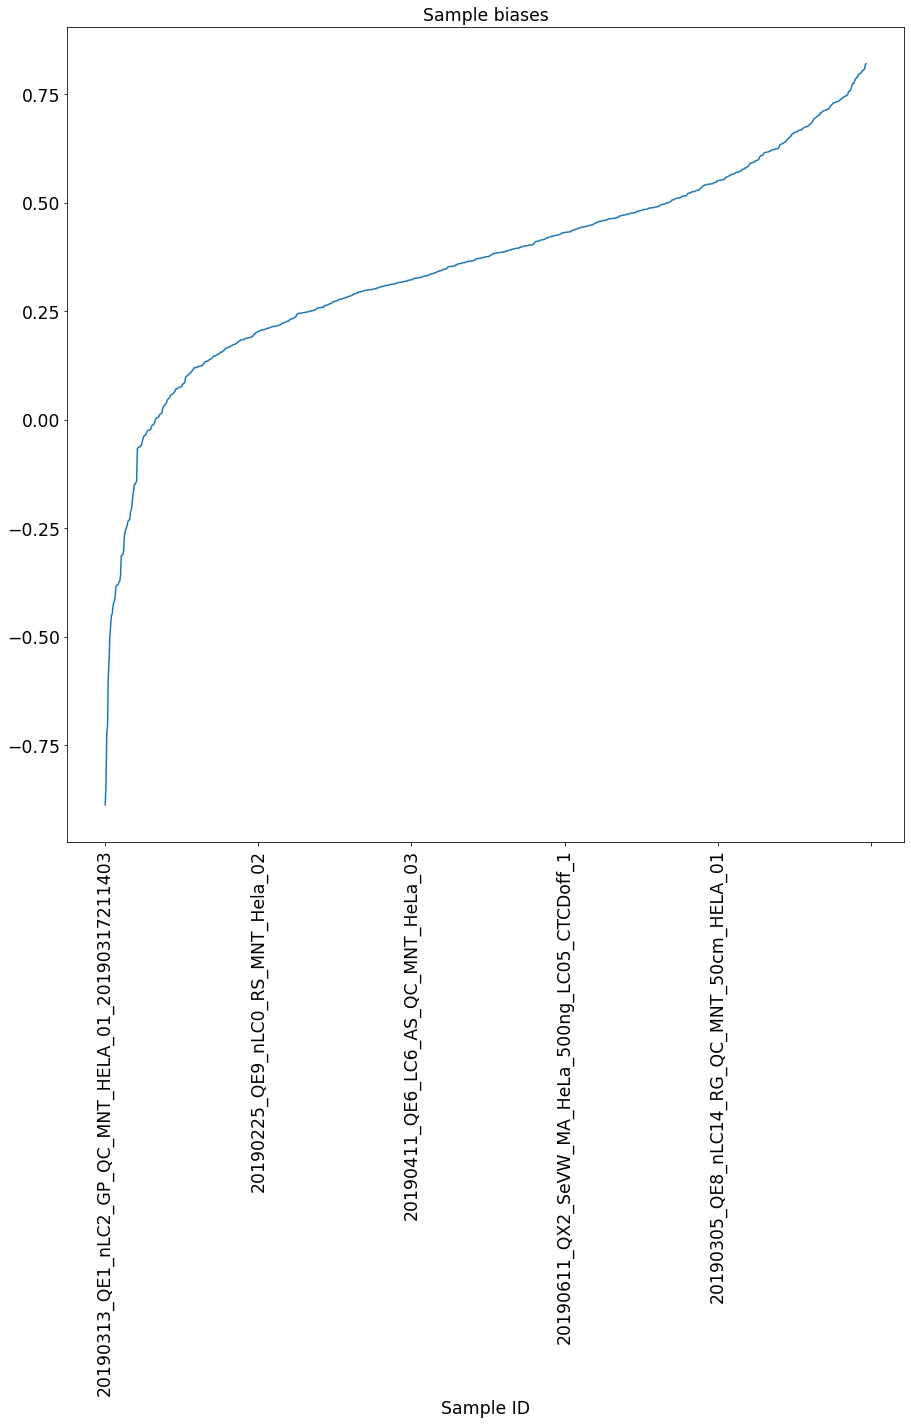

In [45]:
fig, ax = plt.subplots(figsize=(15, 15))
ax = collab.biases.sample.sort_values().plot(kind='line', rot=90, title='Sample biases', ax=ax)
vaep.io_images._savefig(fig, name='collab_bias_samples',
                        folder=folder)

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\collab_bias_peptides


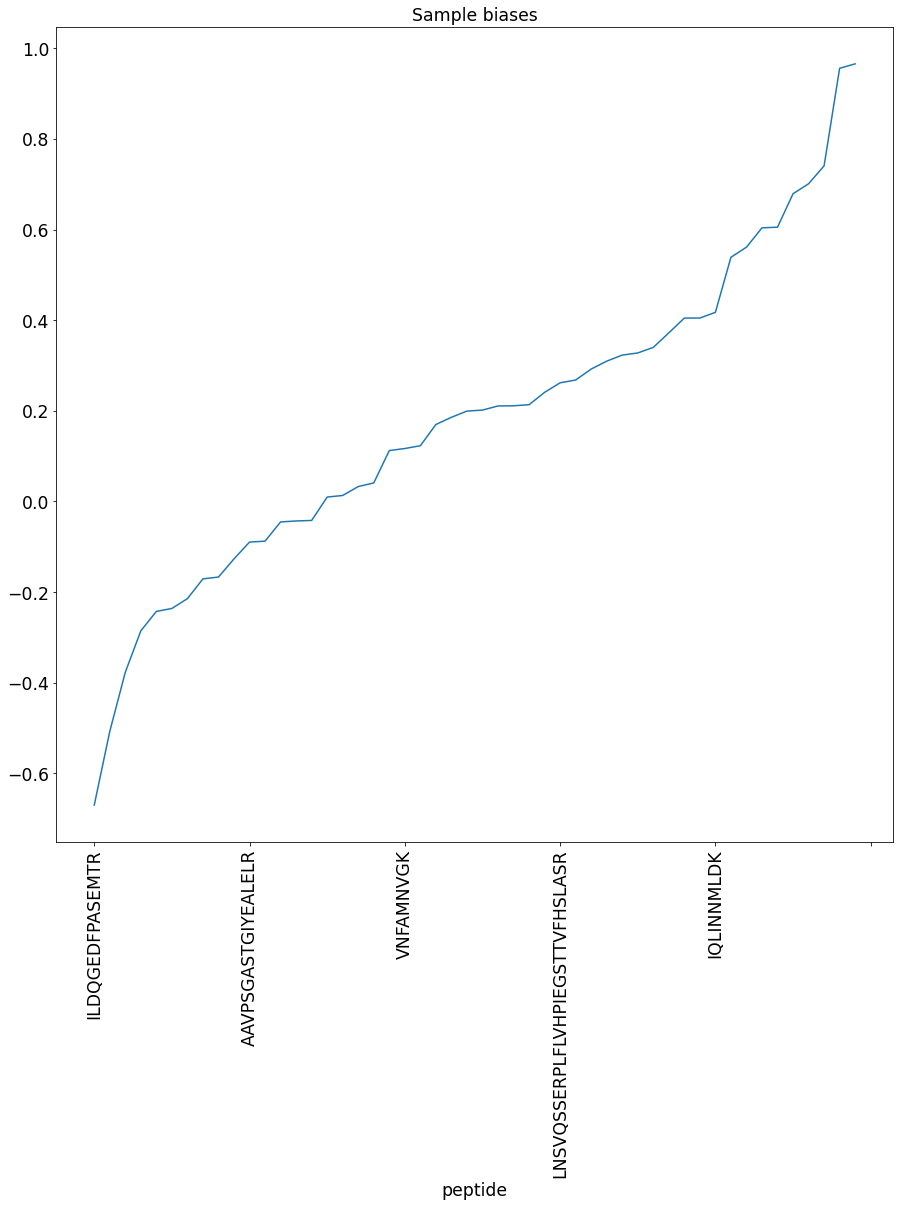

In [46]:
fig, ax = plt.subplots(figsize=(15, 15))
_ = collab.biases.peptide.sort_values().plot(kind='line', rot=90, title='Sample biases', ax=ax)
vaep.io_images._savefig(fig, name='collab_bias_peptides',
                        folder=folder)

In [47]:
def get_weight(learner, indices, is_item=True) -> pd.Series:
    ret = learner.model.weight(indices.values, is_item=is_item) # user=sample
    return pd.DataFrame(ret, index=indices, columns=[f'latent dimension {i+1}' for i in range(ret.shape[-1])])

collab.embeddings = CollabIDs(
    sample=get_weight(learn, indices=analysis.df_train.index.levels[0], is_item=False), # item=peptide
    peptide=get_weight(learn, indices=analysis.df_train.index.levels[1] )
)
collab.embeddings.sample.head()

,latent dimension 1,latent dimension 2
Sample ID,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,0.301,0.186
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,0.155,0.225
20181221_QE8_nLC0_NHS_MNT_HeLa_01,-0.065,0.045
20181222_QE9_nLC9_QC_50CM_HeLa1,0.112,0.280
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,0.184,0.138


vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\collab_latent_by_date


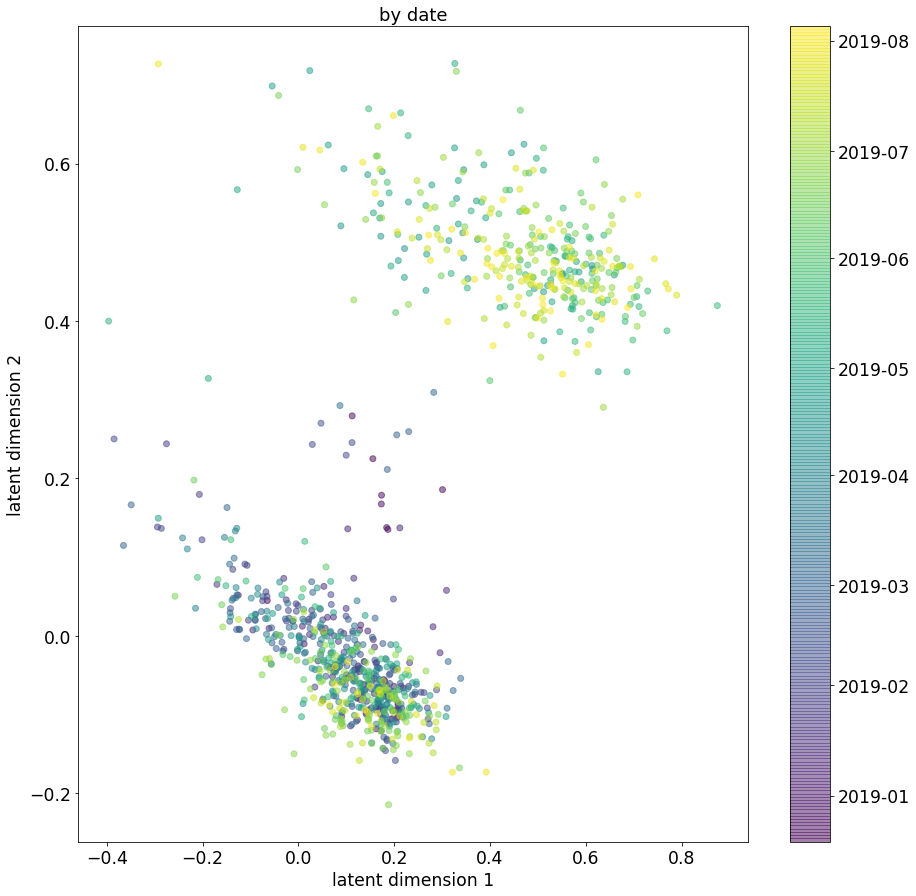

In [48]:
fig, ax = plt.subplots(figsize=(15, 15))
analyzers.plot_date_map(df=collab.embeddings.sample, fig=fig, ax=ax,
                        dates=analysis.df_meta.date.loc[collab.embeddings.sample.index])
vaep.io_images._savefig(fig, name='collab_latent_by_date',
                        folder=folder)

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\collab_latent_by_ms_instrument


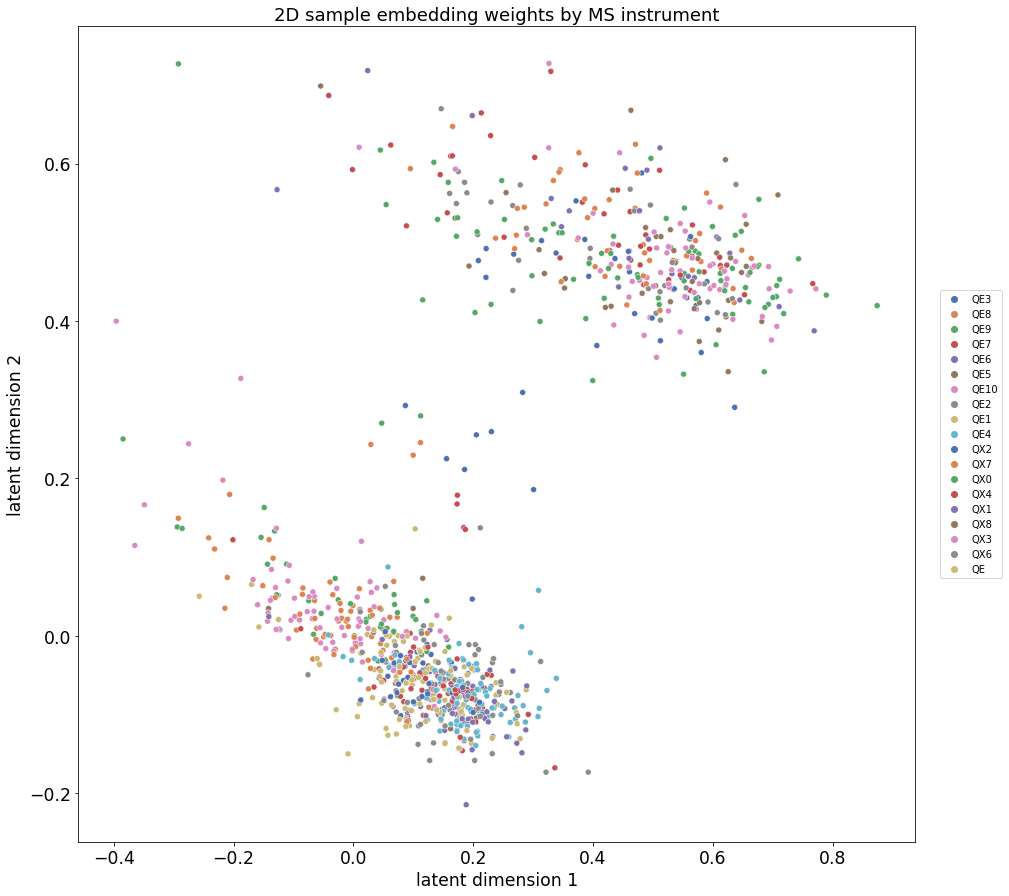

In [49]:
fig, ax = plt.subplots(figsize=(15, 15))
meta_col = 'ms_instrument'

df_ = collab.embeddings.sample
analyzers.seaborn_scatter(df=df_,
                          fig=fig,
                          ax=ax,
                          meta=analysis.df_meta[meta_col].loc[df_.index],
                          title='2D sample embedding weights by MS instrument')

vaep.io_images._savefig(fig, name='collab_latent_by_ms_instrument',
                        folder=folder)

## Denoising Autoencoder (DAE)

### Custom Transforms

- [x] Shift standard normalized data around
    - Error metrics won't be directly comparable afterwards

In [50]:
from fastai.tabular.all import *
from vaep.models import ae

from fastai.tabular.core import TabularPandas

# from fastai.callback.core import Callback

from fastai.data.core import DataLoaders

from fastai.learner import Learner
from fastai.losses import MSELossFlat


# https://docs.fast.ai/tabular.core.html#FillStrategy
# from fastai.tabular.core import FillMissing
# from fastai.tabular.core import TabularPandas

### DataLoaders

In [51]:
# revert format
# undo using `stack`
analysis.df_train = analysis.df_train['intensity'].unstack()
analysis.df_valid = analysis.df_valid['intensity'].unstack()
analysis.df_valid.head()

peptide,AAVPSGASTGIYEALELR,ACANPAAGSVILLENLR,AHGPGLEGGLVGKPAEFTIDTK,AQLLQPTLEINPR,ATAVVDGAFK,ATQALVLAPTR,DFTVSAMHGDMDQK,DVQIGDIVTVGECRPLSK,EHALLAYTLGVK,ELSDIAHR,...,THLPGFVEQAEALK,TITLEVEPSDTIENVK,TLQIFNIEMK,TTHFVEGGDAGNREDQINR,TYDATTHFETTCDDIK,VAYVSFGPHAGK,VLITTDLLAR,VLTVINQTQK,VNFAMNVGK,YTLPPGVDPTQVSSSLSPEGTLTVEAPMPK
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,30.134,NaN,NaN,NaN,29.988,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,27.540,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,NaN,30.412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.201
20181221_QE8_nLC0_NHS_MNT_HeLa_01,28.291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181222_QE9_nLC9_QC_50CM_HeLa1,NaN,NaN,NaN,27.990,30.036,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.004,NaN,NaN
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,NaN,NaN,NaN,NaN,30.067,NaN,NaN,NaN,31.808,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Mean and std. dev. from training data

In [52]:
# norm = Normalize.from_stats(analysis.df_train.mean(), analysis.df_valid.std()) # copy interface?
NORMALIZER = Normalize  # dae.NormalizeShiftedMean

#### Training data

procs passed to TabluarPandas are handled internally 
  1. not necessarily in order
  2. with setup call (using current training data)

In [53]:
procs = [NORMALIZER, FillMissing(add_col=True)]
cont_names = list(analysis.df_train.columns)

to = TabularPandas(analysis.df_train, procs=procs, cont_names=cont_names)
print("Tabular object:", type(to))

to.items  # items reveals data in DataFrame

Tabular object: <class 'fastai.tabular.core.TabularPandas'>


peptide,AAVPSGASTGIYEALELR,ACANPAAGSVILLENLR,AHGPGLEGGLVGKPAEFTIDTK,AQLLQPTLEINPR,ATAVVDGAFK,ATQALVLAPTR,DFTVSAMHGDMDQK,DVQIGDIVTVGECRPLSK,EHALLAYTLGVK,ELSDIAHR,...,THLPGFVEQAEALK_na,TITLEVEPSDTIENVK_na,TLQIFNIEMK_na,TTHFVEGGDAGNREDQINR_na,TYDATTHFETTCDDIK_na,VAYVSFGPHAGK_na,VLITTDLLAR_na,VLTVINQTQK_na,VNFAMNVGK_na,YTLPPGVDPTQVSSSLSPEGTLTVEAPMPK_na
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,-0.394,-0.655,-0.853,-0.933,0.137,0.026,-1.308,-0.091,-0.055,-0.709,...,False,False,True,False,False,False,False,False,False,False
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.019,0.178,-0.787,-1.052,0.015,0.037,-1.329,-0.159,-0.172,-0.199,...,False,False,False,False,False,False,False,False,False,True
20181221_QE8_nLC0_NHS_MNT_HeLa_01,-0.394,0.228,-0.185,-0.331,-0.033,-0.636,-0.782,-0.514,-1.805,-0.699,...,False,False,False,False,False,False,False,False,False,False
20181222_QE9_nLC9_QC_50CM_HeLa1,0.164,-0.453,-1.056,-0.125,0.137,0.065,-1.178,0.208,-0.031,-0.336,...,False,False,False,False,False,False,False,True,False,False
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,0.698,0.798,-0.794,-0.607,0.137,0.116,-1.240,0.133,-0.036,-1.020,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,1.547,0.920,-0.598,1.006,0.413,1.046,0.579,1.288,0.667,0.769,...,True,False,False,False,False,False,False,False,False,False
20190805_QE1_nLC2_AB_MNT_HELA_01,-0.643,0.241,0.211,-0.236,0.412,-0.707,0.567,-0.079,-0.572,0.021,...,False,True,False,False,False,False,False,False,False,True
20190805_QE1_nLC2_AB_MNT_HELA_02,-0.614,0.178,0.425,-0.532,0.268,-0.818,0.450,-0.084,0.456,-0.019,...,False,False,False,False,False,False,False,False,False,False


Better manuelly apply `Transforms` on `Tabluar` type

In [54]:
cont_names = list(analysis.df_train.columns)
to = TabularPandas(analysis.df_train, cont_names=cont_names, do_setup=False)

tf_norm = NORMALIZER()
_ = tf_norm.setups(to)  # returns to
tf_fillna = FillMissing(add_col=True)
_ = tf_fillna.setup(to)

print("Tabular object:", type(to))
# _ = (procs[0]).encodes(to)
to.items  # items reveals data in DataFrame

Tabular object: <class 'fastai.tabular.core.TabularPandas'>


peptide,AAVPSGASTGIYEALELR,ACANPAAGSVILLENLR,AHGPGLEGGLVGKPAEFTIDTK,AQLLQPTLEINPR,ATAVVDGAFK,ATQALVLAPTR,DFTVSAMHGDMDQK,DVQIGDIVTVGECRPLSK,EHALLAYTLGVK,ELSDIAHR,...,THLPGFVEQAEALK_na,TITLEVEPSDTIENVK_na,TLQIFNIEMK_na,TTHFVEGGDAGNREDQINR_na,TYDATTHFETTCDDIK_na,VAYVSFGPHAGK_na,VLITTDLLAR_na,VLTVINQTQK_na,VNFAMNVGK_na,YTLPPGVDPTQVSSSLSPEGTLTVEAPMPK_na
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,-0.431,-0.582,-0.767,-0.898,0.147,-0.014,-1.235,-0.096,-0.056,-0.662,...,False,False,True,False,False,False,False,False,False,False
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.079,0.192,-0.706,-1.011,0.032,-0.004,-1.254,-0.159,-0.167,-0.179,...,False,False,False,False,False,False,False,False,False,True
20181221_QE8_nLC0_NHS_MNT_HeLa_01,-0.431,0.238,-0.143,-0.327,-0.013,-0.634,-0.736,-0.493,-1.716,-0.652,...,False,False,False,False,False,False,False,False,False,False
20181222_QE9_nLC9_QC_50CM_HeLa1,0.093,-0.394,-0.957,-0.132,0.147,0.022,-1.111,0.186,-0.033,-0.309,...,False,False,False,False,False,False,False,True,False,False
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,0.595,0.769,-0.712,-0.589,0.147,0.071,-1.170,0.115,-0.038,-0.956,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,1.392,0.883,-0.529,0.940,0.405,0.941,0.553,1.199,0.629,0.737,...,True,False,False,False,False,False,False,False,False,False
20190805_QE1_nLC2_AB_MNT_HELA_01,-0.665,0.251,0.227,-0.237,0.404,-0.701,0.541,-0.085,-0.547,0.029,...,False,True,False,False,False,False,False,False,False,True
20190805_QE1_nLC2_AB_MNT_HELA_02,-0.638,0.192,0.427,-0.518,0.270,-0.804,0.430,-0.089,0.428,-0.009,...,False,False,False,False,False,False,False,False,False,False


Check mean and standard deviation after normalization

In [55]:
to.items.iloc[:, :10].describe()  # not perferct anymore as expected

peptide,AAVPSGASTGIYEALELR,ACANPAAGSVILLENLR,AHGPGLEGGLVGKPAEFTIDTK,AQLLQPTLEINPR,ATAVVDGAFK,ATQALVLAPTR,DFTVSAMHGDMDQK,DVQIGDIVTVGECRPLSK,EHALLAYTLGVK,ELSDIAHR
count,995.000,995.000,995.000,995.000,995.000,995.000,995.000,995.000,995.000,995.000
mean,-0.061,0.027,0.030,-0.014,0.018,-0.038,0.004,-0.010,-0.004,0.009
std,0.939,0.930,0.935,0.949,0.938,0.937,0.947,0.940,0.949,0.947
min,-2.584,-4.841,-4.832,-3.583,-4.463,-3.455,-5.762,-3.589,-4.280,-5.886
25%,-0.714,-0.364,-0.230,-0.543,-0.190,-0.626,-0.388,-0.412,-0.535,-0.327
50%,-0.431,0.192,0.227,-0.132,0.147,-0.288,0.040,-0.085,-0.038,0.087
75%,0.914,0.623,0.608,0.475,0.500,0.712,0.490,0.497,0.637,0.549
max,1.911,1.894,2.201,2.357,1.719,2.122,2.062,2.222,1.857,1.810


Mask is added as type bool

In [56]:
to.items.dtypes.value_counts()

float64   50
bool      50
dtype: int64

with the suffix `_na` where `True` is indicating a missing value replaced by the `FillMissing` transformation

In [57]:
to.cont_names, to.cat_names

((#50) ['AAVPSGASTGIYEALELR','ACANPAAGSVILLENLR','AHGPGLEGGLVGKPAEFTIDTK','AQLLQPTLEINPR','ATAVVDGAFK','ATQALVLAPTR','DFTVSAMHGDMDQK','DVQIGDIVTVGECRPLSK','EHALLAYTLGVK','ELSDIAHR'...],
 (#50) ['AAVPSGASTGIYEALELR_na','ACANPAAGSVILLENLR_na','AHGPGLEGGLVGKPAEFTIDTK_na','AQLLQPTLEINPR_na','ATAVVDGAFK_na','ATQALVLAPTR_na','DFTVSAMHGDMDQK_na','DVQIGDIVTVGECRPLSK_na','EHALLAYTLGVK_na','ELSDIAHR_na'...])

In [58]:
assert len(to.valid) == 0

#### Validation data

- reuse training data with different mask for evaluation
- target data is the validation data
    - switch between training and evaluation mode for setting comparison

In [59]:
_df_valid = TabularPandas(
    analysis.df_valid, cont_names=analysis.df_valid.columns.tolist())
# assert analysis.df_valid.isna().equals(y_valid.items.isna())
_df_valid = tf_norm.encodes(_df_valid)

In [60]:
_df_valid.items.iloc[:, :10].describe()

peptide,AAVPSGASTGIYEALELR,ACANPAAGSVILLENLR,AHGPGLEGGLVGKPAEFTIDTK,AQLLQPTLEINPR,ATAVVDGAFK,ATQALVLAPTR,DFTVSAMHGDMDQK,DVQIGDIVTVGECRPLSK,EHALLAYTLGVK,ELSDIAHR
count,95.000,96.000,96.000,100.000,97.000,97.000,100.000,98.000,100.000,99.000
mean,-0.103,0.200,-0.072,0.053,0.058,-0.037,0.134,0.072,-0.079,-0.167
std,0.934,0.998,1.009,0.979,1.055,0.934,1.046,0.995,1.038,1.140
min,-1.973,-3.288,-3.022,-2.810,-3.459,-1.840,-4.763,-3.069,-3.687,-5.201
25%,-0.746,-0.131,-0.623,-0.567,-0.255,-0.723,-0.270,-0.544,-0.519,-0.568
50%,-0.493,0.344,0.212,-0.080,0.246,-0.302,0.118,-0.026,-0.112,-0.124
75%,0.808,0.891,0.625,0.960,0.718,0.704,0.680,0.967,0.602,0.457
max,1.674,2.101,1.518,1.947,1.636,2.235,2.016,1.790,1.814,1.437


In [61]:
# Validation dataset
# build validation DataFrame with mask according to validation data
# FillNA values in data as before, but do not add categorical columns (as this is done manuelly)
_valid_df = to.conts  # same data for predictions
_valid_df = _valid_df.join(analysis.df_valid.isna(), rsuffix='_na')  # mask
_valid_df = _valid_df.join(_df_valid.items, rsuffix='_val')  # target
_valid_df

peptide,AAVPSGASTGIYEALELR,ACANPAAGSVILLENLR,AHGPGLEGGLVGKPAEFTIDTK,AQLLQPTLEINPR,ATAVVDGAFK,ATQALVLAPTR,DFTVSAMHGDMDQK,DVQIGDIVTVGECRPLSK,EHALLAYTLGVK,ELSDIAHR,...,THLPGFVEQAEALK_val,TITLEVEPSDTIENVK_val,TLQIFNIEMK_val,TTHFVEGGDAGNREDQINR_val,TYDATTHFETTCDDIK_val,VAYVSFGPHAGK_val,VLITTDLLAR_val,VLTVINQTQK_val,VNFAMNVGK_val,YTLPPGVDPTQVSSSLSPEGTLTVEAPMPK_val
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,-0.431,-0.582,-0.767,-0.898,0.147,-0.014,-1.235,-0.096,-0.056,-0.662,...,NaN,NaN,-0.909,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.079,0.192,-0.706,-1.011,0.032,-0.004,-1.254,-0.159,-0.167,-0.179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.456
20181221_QE8_nLC0_NHS_MNT_HeLa_01,-0.431,0.238,-0.143,-0.327,-0.013,-0.634,-0.736,-0.493,-1.716,-0.652,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181222_QE9_nLC9_QC_50CM_HeLa1,0.093,-0.394,-0.957,-0.132,0.147,0.022,-1.111,0.186,-0.033,-0.309,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.649,NaN,NaN
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,0.595,0.769,-0.712,-0.589,0.147,0.071,-1.170,0.115,-0.038,-0.956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,1.392,0.883,-0.529,0.940,0.405,0.941,0.553,1.199,0.629,0.737,...,0.985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190805_QE1_nLC2_AB_MNT_HELA_01,-0.665,0.251,0.227,-0.237,0.404,-0.701,0.541,-0.085,-0.547,0.029,...,NaN,-0.381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.154
20190805_QE1_nLC2_AB_MNT_HELA_02,-0.638,0.192,0.427,-0.518,0.270,-0.804,0.430,-0.089,0.428,-0.009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
# [norm, FillMissing(add_col=False)]  # mask is provided explicitly
procs = None

cont_names = list(analysis.df_train.columns)
cat_names = [f'{s}_na' for s in cont_names]
y_names = [f'{s}_val' for s in cont_names]

splits = None
y_block = None
to_valid = TabularPandas(_valid_df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                         y_names=y_names, splits=splits, y_block=y_block, do_setup=True)
to_valid.items

peptide,AAVPSGASTGIYEALELR,ACANPAAGSVILLENLR,AHGPGLEGGLVGKPAEFTIDTK,AQLLQPTLEINPR,ATAVVDGAFK,ATQALVLAPTR,DFTVSAMHGDMDQK,DVQIGDIVTVGECRPLSK,EHALLAYTLGVK,ELSDIAHR,...,THLPGFVEQAEALK_val,TITLEVEPSDTIENVK_val,TLQIFNIEMK_val,TTHFVEGGDAGNREDQINR_val,TYDATTHFETTCDDIK_val,VAYVSFGPHAGK_val,VLITTDLLAR_val,VLTVINQTQK_val,VNFAMNVGK_val,YTLPPGVDPTQVSSSLSPEGTLTVEAPMPK_val
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,-0.431,-0.582,-0.767,-0.898,0.147,-0.014,-1.235,-0.096,-0.056,-0.662,...,NaN,NaN,-0.909,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.079,0.192,-0.706,-1.011,0.032,-0.004,-1.254,-0.159,-0.167,-0.179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.456
20181221_QE8_nLC0_NHS_MNT_HeLa_01,-0.431,0.238,-0.143,-0.327,-0.013,-0.634,-0.736,-0.493,-1.716,-0.652,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181222_QE9_nLC9_QC_50CM_HeLa1,0.093,-0.394,-0.957,-0.132,0.147,0.022,-1.111,0.186,-0.033,-0.309,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.649,NaN,NaN
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,0.595,0.769,-0.712,-0.589,0.147,0.071,-1.170,0.115,-0.038,-0.956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,1.392,0.883,-0.529,0.940,0.405,0.941,0.553,1.199,0.629,0.737,...,0.985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190805_QE1_nLC2_AB_MNT_HELA_01,-0.665,0.251,0.227,-0.237,0.404,-0.701,0.541,-0.085,-0.547,0.029,...,NaN,-0.381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.154
20190805_QE1_nLC2_AB_MNT_HELA_02,-0.638,0.192,0.427,-0.518,0.270,-0.804,0.430,-0.089,0.428,-0.009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
stats_valid = to_valid.targ.iloc[:, :100].describe()
stats_valid

peptide,AAVPSGASTGIYEALELR_val,ACANPAAGSVILLENLR_val,AHGPGLEGGLVGKPAEFTIDTK_val,AQLLQPTLEINPR_val,ATAVVDGAFK_val,ATQALVLAPTR_val,DFTVSAMHGDMDQK_val,DVQIGDIVTVGECRPLSK_val,EHALLAYTLGVK_val,ELSDIAHR_val,...,THLPGFVEQAEALK_val,TITLEVEPSDTIENVK_val,TLQIFNIEMK_val,TTHFVEGGDAGNREDQINR_val,TYDATTHFETTCDDIK_val,VAYVSFGPHAGK_val,VLITTDLLAR_val,VLTVINQTQK_val,VNFAMNVGK_val,YTLPPGVDPTQVSSSLSPEGTLTVEAPMPK_val
count,95.000,96.000,96.000,100.000,97.000,97.000,100.000,98.000,100.000,99.000,...,100.000,100.000,99.000,100.000,100.000,98.000,100.000,99.000,99.000,100.000
mean,-0.103,0.200,-0.072,0.053,0.058,-0.037,0.134,0.072,-0.079,-0.167,...,-0.096,0.031,-0.047,-0.095,0.002,-0.036,-0.065,0.001,-0.091,-0.025
std,0.934,0.998,1.009,0.979,1.055,0.934,1.046,0.995,1.038,1.140,...,0.978,0.864,1.112,1.200,0.818,1.011,0.856,1.014,0.927,1.111
min,-1.973,-3.288,-3.022,-2.810,-3.459,-1.840,-4.763,-3.069,-3.687,-5.201,...,-2.599,-3.113,-4.150,-4.475,-2.566,-3.952,-2.831,-3.588,-2.387,-3.512
25%,-0.746,-0.131,-0.623,-0.567,-0.255,-0.723,-0.270,-0.544,-0.519,-0.568,...,-0.627,-0.426,-0.232,-0.852,-0.521,-0.418,-0.566,-0.448,-0.607,-0.534
50%,-0.493,0.344,0.212,-0.080,0.246,-0.302,0.118,-0.026,-0.112,-0.124,...,-0.137,0.139,0.241,-0.309,-0.003,0.039,-0.041,0.035,-0.338,0.089
75%,0.808,0.891,0.625,0.960,0.718,0.704,0.680,0.967,0.602,0.457,...,0.413,0.598,0.610,1.036,0.293,0.539,0.397,0.760,0.637,0.608
max,1.674,2.101,1.518,1.947,1.636,2.235,2.016,1.790,1.814,1.437,...,2.032,1.806,1.480,2.127,1.864,1.925,1.620,1.588,1.870,2.410


In [64]:
# True = training data ("fill_na" transform sets mask to true in training data where values are replaced)
to_valid.cats

peptide,AAVPSGASTGIYEALELR_na,ACANPAAGSVILLENLR_na,AHGPGLEGGLVGKPAEFTIDTK_na,AQLLQPTLEINPR_na,ATAVVDGAFK_na,ATQALVLAPTR_na,DFTVSAMHGDMDQK_na,DVQIGDIVTVGECRPLSK_na,EHALLAYTLGVK_na,ELSDIAHR_na,...,THLPGFVEQAEALK_na,TITLEVEPSDTIENVK_na,TLQIFNIEMK_na,TTHFVEGGDAGNREDQINR_na,TYDATTHFETTCDDIK_na,VAYVSFGPHAGK_na,VLITTDLLAR_na,VLTVINQTQK_na,VNFAMNVGK_na,YTLPPGVDPTQVSSSLSPEGTLTVEAPMPK_na
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,False,True,True,True,False,True,True,True,True,True,...,True,True,False,True,True,True,True,True,True,True
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,True,False,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,False
20181221_QE8_nLC0_NHS_MNT_HeLa_01,False,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
20181222_QE9_nLC9_QC_50CM_HeLa1,True,True,True,False,False,True,True,True,True,True,...,True,True,True,True,True,True,True,False,True,True
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,True,True,True,True,False,True,True,True,False,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,True,True,True,True,True,True,True,True,True,True,...,False,True,True,True,True,True,True,True,True,True
20190805_QE1_nLC2_AB_MNT_HELA_01,True,True,False,True,True,True,True,False,True,True,...,True,False,True,True,True,True,True,True,True,False
20190805_QE1_nLC2_AB_MNT_HELA_02,True,False,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [65]:
assert list(to_valid.cat_names) == list(
    _valid_df.select_dtypes(include='bool').columns)  # 'object'
assert to_valid.cats.equals(analysis.df_valid.isna().add_suffix('_na'))

### Mix and match dataloaders

- train dataloader in both TabularPandas objects used
- train dataloader in dataloaders used in both case

In [66]:
args.batch_size
dl_train = to.dataloaders(shuffle_train=True, shuffle=False,
                          bs=args.batch_size).train  # , after_batch=after_batch)
dl_valid = to_valid.dataloaders(
    shuffle_train=False, shuffle=False, bs=args.batch_size).train

In [67]:
dls = DataLoaders(dl_train, dl_valid)
b = dls.train.one_batch()
[x.shape for x in b]  # cat, cont, target

[torch.Size([32, 50]), torch.Size([32, 50]), torch.Size([32, 0])]

In [68]:
dls = DataLoaders(dl_train, dl_valid)
b = dls.valid.one_batch()
[x.shape for x in b]  # cat, cont, target

[torch.Size([32, 50]), torch.Size([32, 50]), torch.Size([32, 50])]

### Model

- standard PyTorch Model from before

In [69]:
M = analysis.df_train.shape[-1]
model = ae.Autoencoder(n_features=M, n_neurons=int(
    M/2), last_decoder_activation=None, dim_latent=latent_dim)

### Callbacks

- controll training loop
    - set what is data
    - what should be used for evaluation (differs for training and evaluation mode)

In [70]:
ae.ModelAdapter

vaep.models.ae.ModelAdapter

### Learner: Fastai Training Loop

In [71]:
learn = Learner(dls=dls, model=model,
                loss_func=MSELossFlat(), cbs=ae.ModelAdapter())

In [72]:
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [ModelAdapter]
         - after_pred     : [ModelAdapter]
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, ModelAdapter, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, Progress

In [73]:
learn.summary()

Autoencoder (Input shape: 32 x 50)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 25             
Linear                                    1275       True      
Tanh                                                           
____________________________________________________________________________
                     32 x 2              
Linear                                    52         True      
Tanh                                                           
____________________________________________________________________________
                     32 x 25             
Linear                                    75         True      
Tanh                                                           
____________________________________________________________________________
                     32 x 50             
Linear                                    1300       True      
______________________________________________________

SuggestedLRs(valley=0.0063095735386013985)

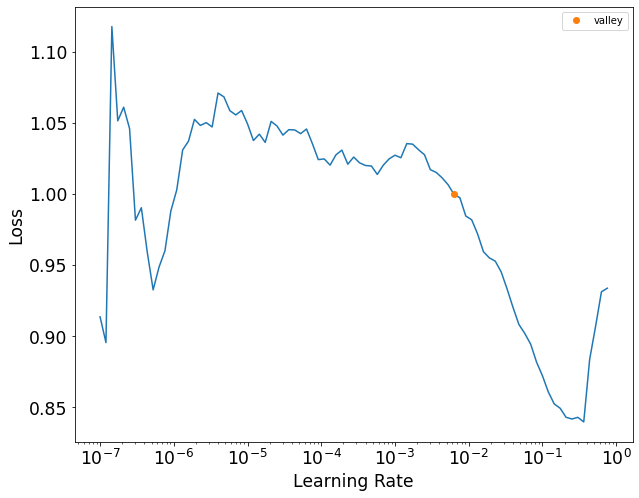

In [74]:
suggested_lr = learn.lr_find()
suggested_lr

### Training

In [75]:
learn.fit_one_cycle(epochs_max, lr_max=suggested_lr.valley)

epoch,train_loss,valid_loss,time
0,0.960389,0.800686,00:00
1,0.694432,0.406642,00:00
2,0.509491,0.344599,00:00
3,0.416974,0.323897,00:00
4,0.369971,0.312906,00:00
5,0.340372,0.306111,00:00
6,0.323770,0.304895,00:00
7,0.313772,0.302952,00:00
8,0.305704,0.300414,00:00
9,0.302792,0.301964,00:00


In [76]:
# learn.val_preds, learn.val_targets #

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\dae_training


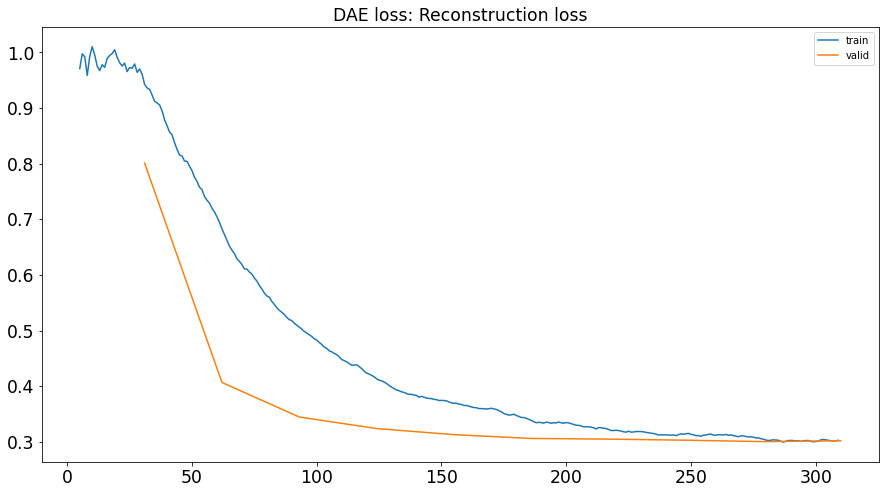

In [77]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title('DAE loss: Reconstruction loss')
learn.recorder.plot_loss(skip_start=5, ax=ax)
vaep.io_images._savefig(fig, name='dae_training',
                        folder=folder)

In [78]:
# L(zip(learn.recorder.iters, learn.recorder.values))


### Evaluation

In [79]:
# reorder True: Only 500 predictions returned
pred, target = learn.get_preds(act=noop, concat_dim=0, reorder=False)
len(pred), len(target)

(4928, 4928)

MSE on transformed data is not too interesting for comparision between models if these use different standardizations

In [80]:
learn.loss_func(pred, target)  # MSE in transformed space not too interesting

TensorBase(0.3005)

In [81]:
# check target is in expected order
Y = dls.valid.targ

npt.assert_almost_equal(
    actual=target.numpy(),
    desired=Y.stack().to_numpy()
)

In [82]:
# import torch
# from fastai.tabular.core import TabularPandas

df_pred['intensity_pred_dae'] = ae.transform_preds(
    pred=pred, index=analysis.df_valid.stack().index, normalizer=tf_norm)
df_pred

intensity  \
Sample ID                            peptide                         
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AAVPSGASTGIYEALELR     30.134   
                                     ATAVVDGAFK             29.988   
                                     ETNLDSLPLVDTHSK        29.572   
                                     TLQIFNIEMK             27.540   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ACANPAAGSVILLENLR      30.412   
...                                                            ...   
20190805_QE1_nLC2_AB_MNT_HELA_04     ELSDIAHR               31.582   
                                     HLPTLDHPIIPADYVAIK     27.738   
                                     IAGYVTHLMK             30.712   
                                     LMDVGLIAIR             29.522   
                                     SSILLDVKPWDDETDMAK     30.523   

                                                         train_median  \
Sample ID                            peptide                            
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AAVPSGASTGIYEALELR        29.355   
                                     ATAVVDGAFK                30.200   
                                     ETNLDSLPLVDTHSK           29.123   
                                     TLQIFNIEMK                28.825   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ACANPAAGSVILLENLR         31.210   
...                                                               ...   
20190805_QE1_nLC2_AB_MNT_HELA_04     ELSDIAHR                  31.429   
                                     HLPTLDHPIIPADYVAIK        29.776   
                                     IAGYVTHLMK                30.491   
                                     LMDVGLIAIR                29.438   
                                     SSILLDVKPWDDETDMAK        30.107   

                                                         train_average  \
Sample ID                            peptide                             
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AAVPSGASTGIYEALELR         30.376   
                                     ATAVVDGAFK                 30.004   
                                     ETNLDSLPLVDTHSK            29.743   
                                     TLQIFNIEMK                 28.591   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ACANPAAGSVILLENLR          31.017   
...                                                                ...   
20190805_QE1_nLC2_AB_MNT_HELA_04     ELSDIAHR                   31.309   
                                     HLPTLDHPIIPADYVAIK         30.108   
                                     IAGYVTHLMK                 30.395   
                                     LMDVGLIAIR                 29.526   
                                     SSILLDVKPWDDETDMAK         29.931   

                                                         replicates  \
Sample ID                            peptide                          
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AAVPSGASTGIYEALELR      30.189   
                                     ATAVVDGAFK              30.017   
                                     ETNLDSLPLVDTHSK         29.458   
                                     TLQIFNIEMK              27.546   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ACANPAAGSVILLENLR       30.844   
...                                                             ...   
20190805_QE1_nLC2_AB_MNT_HELA_04     ELSDIAHR                31.294   
                                     HLPTLDHPIIPADYVAIK      27.612   
                                     IAGYVTHLMK              31.195   
                                     LMDVGLIAIR              27.558   
                                     SSILLDVKPWDDETDMAK      28.145   

                                                         intensity_pred_collab  \
Sample ID                            peptide                                     
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AAVPSGASTGIYEALELR                 29.939   
                                     ATAVVDGAFK                

### 2D plot of latent space

- 2 dimensional latent space: just plot
- more than 2 dimensional: PCA, etc

In [83]:
latent_space = []
for b in dls.valid:
    model_input = b[1]
    latent_space.append(model.encoder(model_input).detach().numpy())

df_dae_latent = build_df_from_pred_batches(latent_space,
                                           index=_df_valid.items.index,
                                           columns=[f'latent dimension {i+1}' for i in range(latent_dim)])
df_dae_latent.head()

,latent dimension 1,latent dimension 2
Sample ID,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,-0.087,-0.357
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,0.002,-0.282
20181221_QE8_nLC0_NHS_MNT_HeLa_01,0.617,-0.705
20181222_QE9_nLC9_QC_50CM_HeLa1,-0.220,0.133
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,0.323,-0.280


vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\dae_latent_by_date


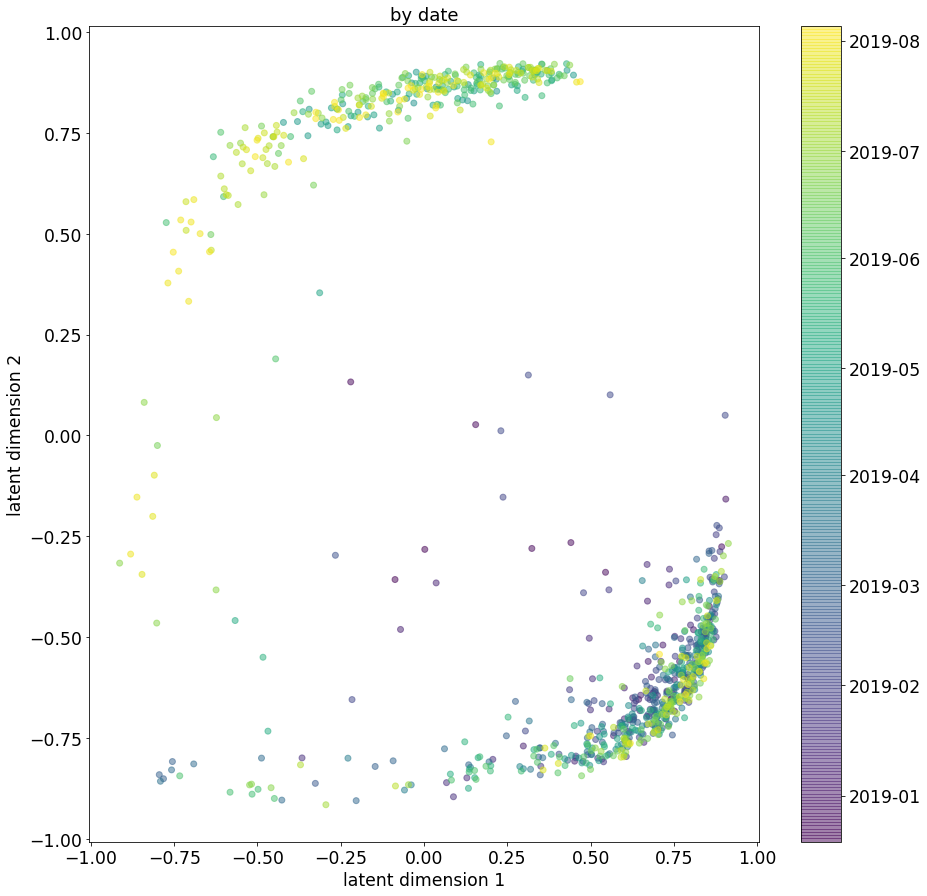

In [84]:
fig, ax = plt.subplots(figsize=(15, 15))
analyzers.plot_date_map(df=df_dae_latent, fig=fig, ax=ax,
                        dates=analysis.df_meta.date.loc[df_dae_latent.index])
vaep.io_images._savefig(fig, name='dae_latent_by_date',
                        folder=folder)

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\dae_latent_by_ms_instrument


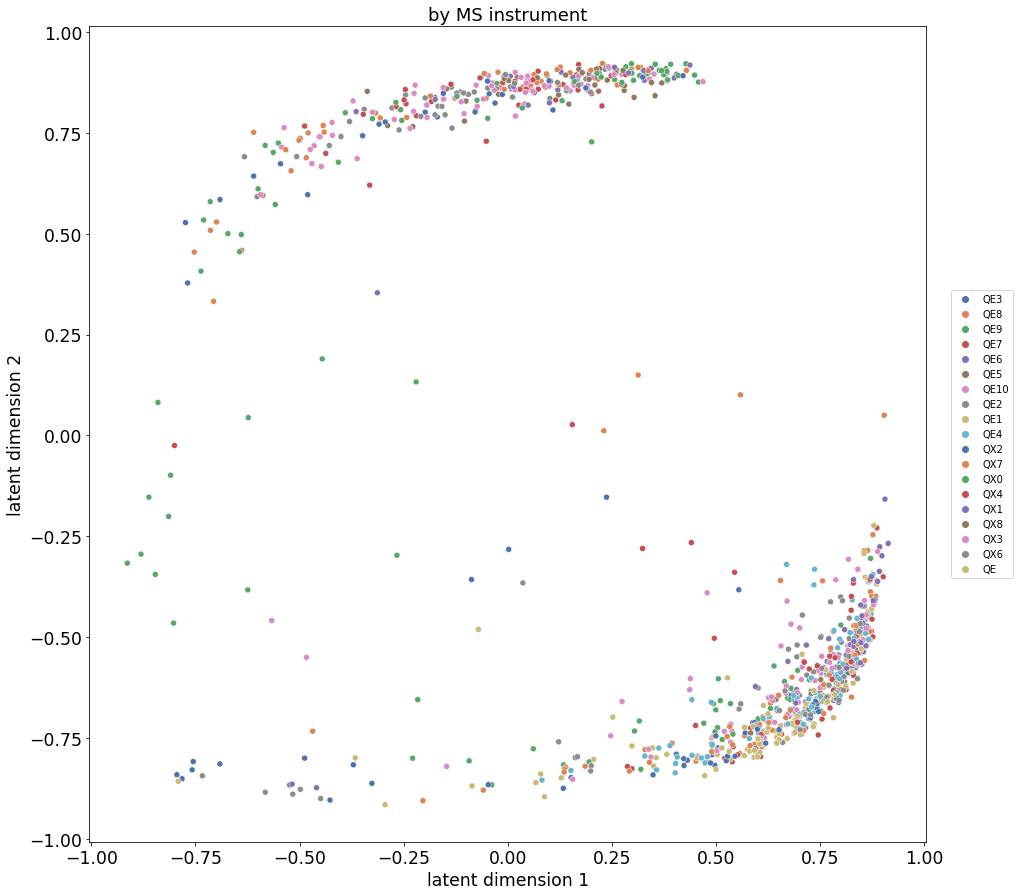

In [85]:
fig, ax = plt.subplots(figsize=(15, 15))

meta_col = 'ms_instrument'

analyzers.seaborn_scatter(df=df_dae_latent,
                          fig=fig,
                          ax=ax,
                          meta=analysis.df_meta[meta_col].loc[df_dae_latent.index],
                          title='by MS instrument')

vaep.io_images._savefig(
    fig, name=f'dae_latent_by_{meta_col}', folder=folder)

## Variational Autoencoder (VAE)

### Scikit Learn MinMaxScaler

- [docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [86]:
from vaep.transform import MinMaxScaler

args_vae = {}
args_vae['SCALER'] = MinMaxScaler
# select initial data: transformed vs not log transformed
scaler = args_vae['SCALER']().fit(analysis.df_train)
scaler.transform(analysis.df_valid.iloc[:5])

peptide,AAVPSGASTGIYEALELR,ACANPAAGSVILLENLR,AHGPGLEGGLVGKPAEFTIDTK,AQLLQPTLEINPR,ATAVVDGAFK,ATQALVLAPTR,DFTVSAMHGDMDQK,DVQIGDIVTVGECRPLSK,EHALLAYTLGVK,ELSDIAHR,...,THLPGFVEQAEALK,TITLEVEPSDTIENVK,TLQIFNIEMK,TTHFVEGGDAGNREDQINR,TYDATTHFETTCDDIK,VAYVSFGPHAGK,VLITTDLLAR,VLTVINQTQK,VNFAMNVGK,YTLPPGVDPTQVSSSLSPEGTLTVEAPMPK
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,0.552,NaN,NaN,NaN,0.720,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.637,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,NaN,0.630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.350
20181221_QE8_nLC0_NHS_MNT_HeLa_01,0.379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181222_QE9_nLC9_QC_50CM_HeLa1,NaN,NaN,NaN,0.537,0.726,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.635,NaN,NaN
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,NaN,NaN,NaN,NaN,0.730,NaN,NaN,NaN,0.703,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### DataLoaders

- follow instructions for using plain PyTorch Datasets, see [tutorial](https://docs.fast.ai/tutorial.siamese.html#Preparing-the-data)


In [87]:
assert all(analysis.df_train.columns == analysis.df_valid.columns)
if not all(analysis.df.columns == analysis.df_train.columns):
    print("analysis.df columns are not the same as analysis.df_train")
    # ToDo: DataLoading has to be cleaned up
    # analysis.df = analysis.df_train.fillna(analysis.df_valid)

analysis.df columns are not the same as analysis.df_train


In [88]:
from vaep.io.datasets import PeptideDatasetInMemory

FILL_NA = 0.0

train_ds = PeptideDatasetInMemory(data=scaler.transform(
    analysis.df_train).to_numpy(dtype=None), fill_na=FILL_NA)
valid_ds = PeptideDatasetInMemory(data=scaler.transform(analysis.df_train.fillna(analysis.df_valid)).to_numpy(dtype=None),
                                  mask=analysis.df_valid.notna().to_numpy(), fill_na=FILL_NA)

assert (train_ds.peptides == valid_ds.peptides).all()

In [89]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, n_inp=2)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


### Model

In [90]:
from torch.nn import Sigmoid

M = analysis.df_train.shape[-1]
model = ae.VAE(n_features=M, n_neurons=int(
    M/2), last_encoder_activation=None, last_decoder_activation=Sigmoid, dim_latent=latent_dim)

### Learner

In [91]:
learn = Learner(dls=dls,
                model=model,
                loss_func=ae.loss_fct_vae,
                cbs=ae.ModelAdapterVAE())

learn.show_training_loop()
learn.summary()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [ModelAdapterVAE]
         - after_pred     : [ModelAdapterVAE]
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback

VAE (Input shape: 64 x 50)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 25             
Linear                                    75         True      
Tanh                                                           
____________________________________________________________________________
                     64 x 50             
Linear                                    1300       True      
Sigmoid                                                        
____________________________________________________________________________
                     64 x 25             
Linear                                    1275       True      
Tanh                                                           
____________________________________________________________________________
                     64 x 4              
Linear                                    104        True      
______________________________________________________________

### Training

SuggestedLRs(valley=0.005248074419796467)

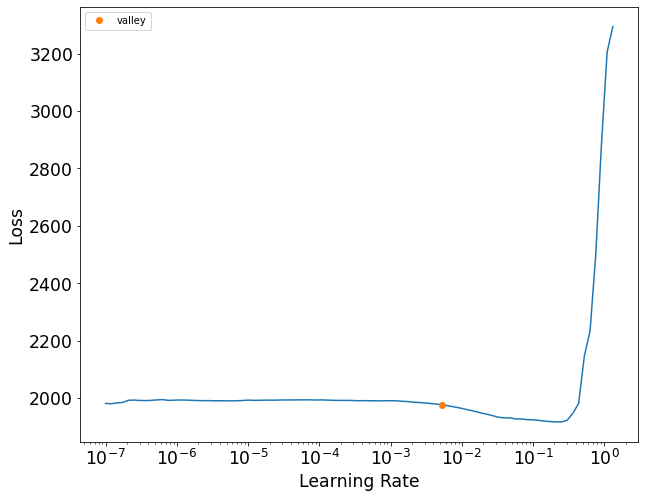

In [92]:
suggested_lr = learn.lr_find()
suggested_lr

In [93]:
learn.fit_one_cycle(epochs_max, lr_max=suggested_lr.valley)

epoch,train_loss,valid_loss,time
0,1978.838623,220.671448,00:00
1,1927.004883,211.857315,00:00
2,1859.598633,200.139099,00:00
3,1816.534546,197.365402,00:00
4,1787.527100,197.981628,00:00
5,1768.001831,203.443756,00:00
6,1753.424316,204.681076,00:00
7,1742.513550,205.166031,00:00
8,1735.343018,205.929565,00:00
9,1730.480957,205.916885,00:00


vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\vae_training


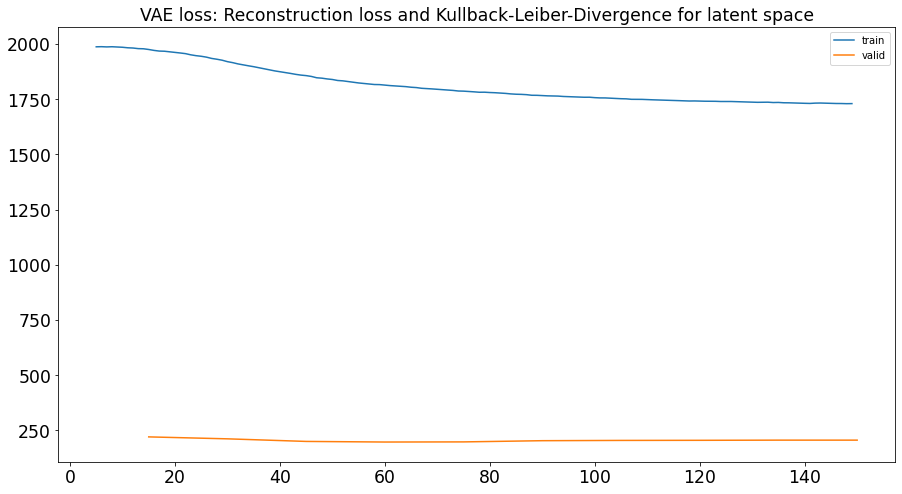

In [94]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title('VAE loss: Reconstruction loss and Kullback-Leiber-Divergence for latent space')
learn.recorder.plot_loss(skip_start=5, ax=ax)
vaep.io_images._savefig(fig, name='vae_training',
                        folder=folder)

### Evaluation

In [95]:
# reorder True: Only 500 predictions returned
pred, target = learn.get_preds(act=noop, concat_dim=0, reorder=False)
len(pred), len(target)

(3, 4928)

In [96]:
len(pred[0])

4928

In [97]:
learn.loss_func(pred, target)

tensor(3249.8103)

In [98]:
_pred = pd.Series(pred[0], index=analysis.df_valid.stack().index).unstack()
_pred = scaler.inverse_transform(_pred).stack()

df_pred['intensity_pred_vae'] = _pred
df_pred

intensity  \
Sample ID                            peptide                         
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AAVPSGASTGIYEALELR     30.134   
                                     ATAVVDGAFK             29.988   
                                     ETNLDSLPLVDTHSK        29.572   
                                     TLQIFNIEMK             27.540   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ACANPAAGSVILLENLR      30.412   
...                                                            ...   
20190805_QE1_nLC2_AB_MNT_HELA_04     ELSDIAHR               31.582   
                                     HLPTLDHPIIPADYVAIK     27.738   
                                     IAGYVTHLMK             30.712   
                                     LMDVGLIAIR             29.522   
                                     SSILLDVKPWDDETDMAK     30.523   

                                                         train_median  \
Sample ID                            peptide                            
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AAVPSGASTGIYEALELR        29.355   
                                     ATAVVDGAFK                30.200   
                                     ETNLDSLPLVDTHSK           29.123   
                                     TLQIFNIEMK                28.825   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ACANPAAGSVILLENLR         31.210   
...                                                               ...   
20190805_QE1_nLC2_AB_MNT_HELA_04     ELSDIAHR                  31.429   
                                     HLPTLDHPIIPADYVAIK        29.776   
                                     IAGYVTHLMK                30.491   
                                     LMDVGLIAIR                29.438   
                                     SSILLDVKPWDDETDMAK        30.107   

                                                         train_average  \
Sample ID                            peptide                             
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AAVPSGASTGIYEALELR         30.376   
                                     ATAVVDGAFK                 30.004   
                                     ETNLDSLPLVDTHSK            29.743   
                                     TLQIFNIEMK                 28.591   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ACANPAAGSVILLENLR          31.017   
...                                                                ...   
20190805_QE1_nLC2_AB_MNT_HELA_04     ELSDIAHR                   31.309   
                                     HLPTLDHPIIPADYVAIK         30.108   
                                     IAGYVTHLMK                 30.395   
                                     LMDVGLIAIR                 29.526   
                                     SSILLDVKPWDDETDMAK         29.931   

                                                         replicates  \
Sample ID                            peptide                          
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AAVPSGASTGIYEALELR      30.189   
                                     ATAVVDGAFK              30.017   
                                     ETNLDSLPLVDTHSK         29.458   
                                     TLQIFNIEMK              27.546   
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01 ACANPAAGSVILLENLR       30.844   
...                                                             ...   
20190805_QE1_nLC2_AB_MNT_HELA_04     ELSDIAHR                31.294   
                                     HLPTLDHPIIPADYVAIK      27.612   
                                     IAGYVTHLMK              31.195   
                                     LMDVGLIAIR              27.558   
                                     SSILLDVKPWDDETDMAK      28.145   

                                                         intensity_pred_collab  \
Sample ID                            peptide                                     
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02  AAVPSGASTGIYEALELR                 29.939   
                                     ATAVVDGAFK                

### Add plot of latent space

- 2 dimensional latent space: just plot
- more than 2 dimensional: PCA, etc

In [99]:
latent_space = []
for b in dls.valid:
    model_input = b[0]
    b_mu, b_std = model.get_mu_and_logvar(model_input, detach=True)
    latent_space.append(b_mu)


df_vae_latent = build_df_from_pred_batches(latent_space,
                                           index=_df_valid.items.index,
                                           columns=[f'latent dimension {i+1}' for i in range(latent_dim)])
df_vae_latent.head()

,latent dimension 1,latent dimension 2
Sample ID,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,0.152,0.039
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,0.057,0.002
20181221_QE8_nLC0_NHS_MNT_HeLa_01,0.510,0.050
20181222_QE9_nLC9_QC_50CM_HeLa1,-0.314,-0.048
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,0.153,0.041


vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\vae_latent_by_date


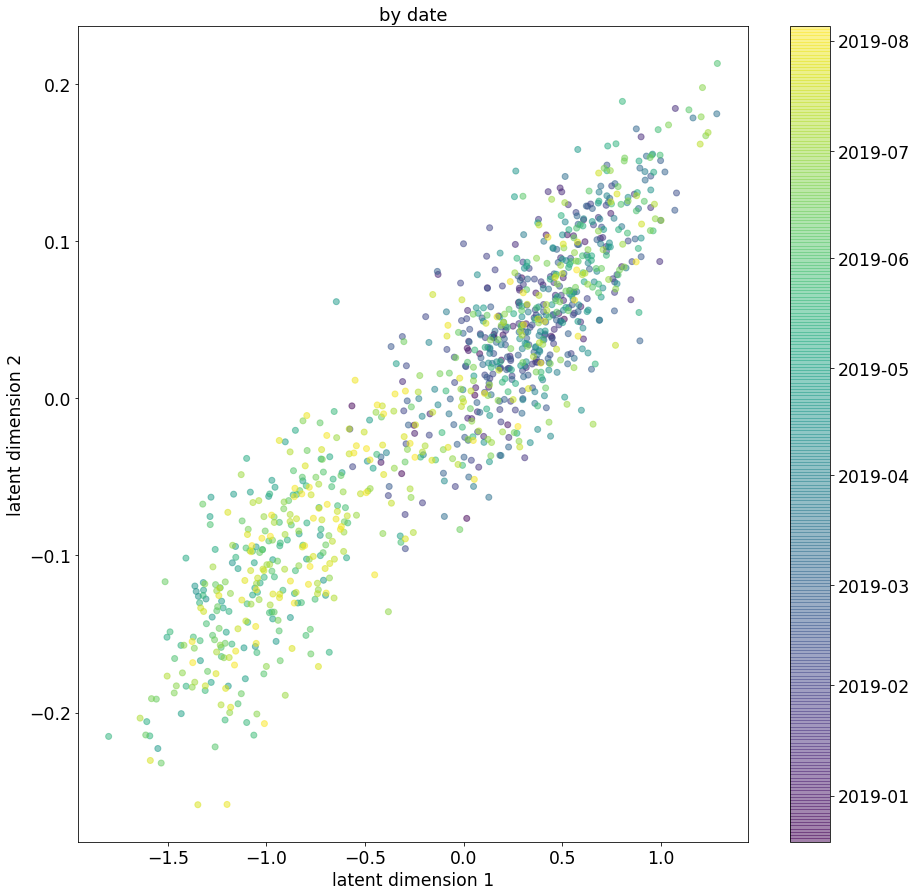

In [100]:
fig, ax = plt.subplots(figsize=(15, 15))
analyzers.plot_date_map(df=df_vae_latent, fig=fig, ax=ax,
                        dates=analysis.df_meta.date.loc[df_vae_latent.index])
vaep.io_images._savefig(fig, name='vae_latent_by_date',
                        folder=folder)

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\vae_latent_by_ms_instrument


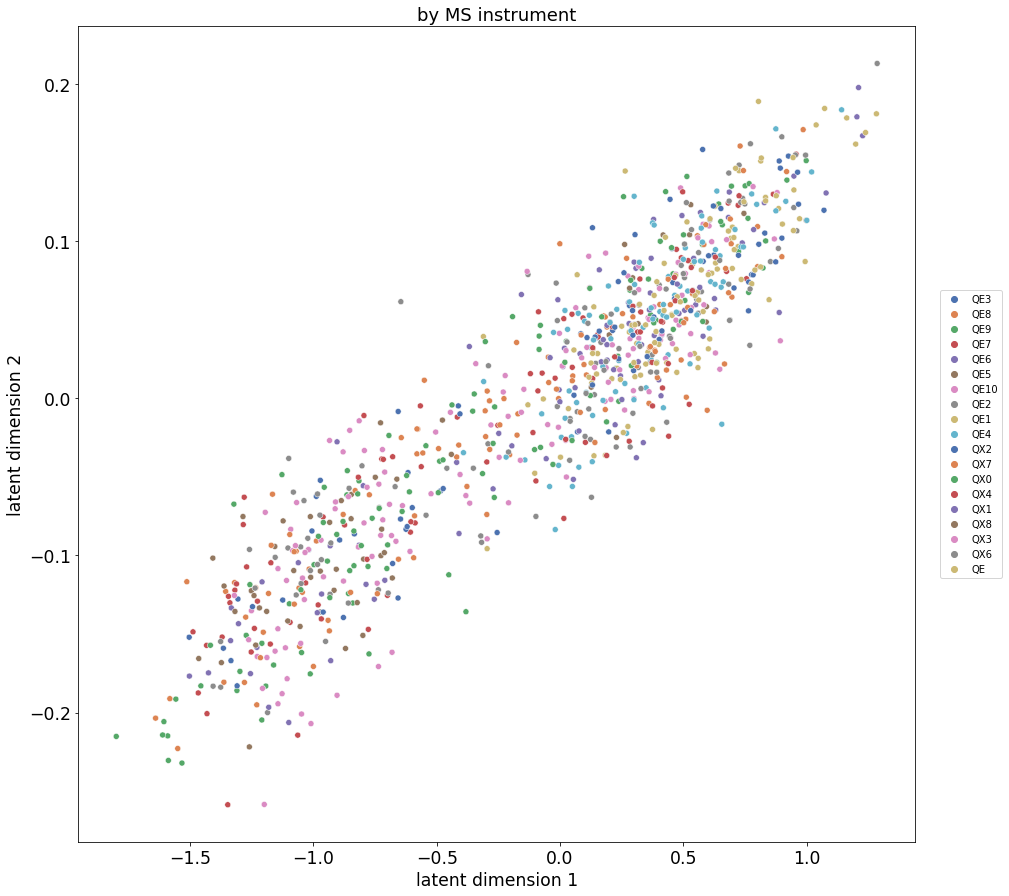

In [101]:
fig, ax = plt.subplots(figsize=(15, 15))

meta_col = 'ms_instrument'

analyzers.seaborn_scatter(df=df_vae_latent,
                          fig=fig,
                          ax=ax,
                          meta=analysis.df_meta[meta_col].loc[df_vae_latent.index],
                          title='by MS instrument')

vaep.io_images._savefig(
    fig, name=f'vae_latent_by_{meta_col}', folder=folder)

## Compare the 3 models

- replicates: replace NAs with neighbouring ("close") values
- train average, median: Replace NA with average or median from training data

In [102]:
import sklearn.metrics as sklm
pred_columns = df_pred.columns[1:]
scoring = [('MSE', sklm.mean_squared_error),
           ('MAE', sklm.mean_absolute_error)]

y_true = df_pred['intensity']

metrics = {}
for col in pred_columns:
    _y_pred = df_pred[col].dropna()
    if len(df_pred[col]) > len(_y_pred):
        logger.info(
            f"Drop indices for {col}: {[(idx[0], idx[1]) for idx in df_pred[col].index.difference(_y_pred.index)]}")

    metrics[col] = dict(
        [(k, f(y_true=y_true.loc[_y_pred.index], y_pred=_y_pred))
         for k, f in scoring]
    )

metrics = pd.DataFrame(metrics)
metrics.to_csv(folder / f'exp_02_metrics.csv',
               float_format='{:.3f}'.format)
metrics.sort_values(by=[k for k, f in scoring], axis=1)

vaep - INFO     Drop indices for replicates: [('20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01', 'ATAVVDGAFK'), ('20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_03', 'LALVTGGEIASTFDHPELVK'), ('20181228_QE6_nLC6_CSC_QC_MNT_HeLa_01', 'FIIPQIVK'), ('20190111_QE2_NLC10_ANHO_QC_MNT_HELA_02', 'FVPAEMGTHTVSVK'), ('20190114_QE4_LC6_IAH_QC_MNT_HeLa_250ng_01', 'LNSVQSSERPLFLVHPIEGSTTVFHSLASR'), ('20190114_QE4_LC6_IAH_QC_MNT_HeLa_250ng_02', 'LNSVQSSERPLFLVHPIEGSTTVFHSLASR'), ('20190121_QE5_nLC5_AH_QC_MNT_HeLa_250ng_02', 'KFDQLLAEEK'), ('20190126_QE6_nLC6_SIS_QC_MNT_HeLa_04', 'LSVLGAITSVQQR'), ('20190129_QE10_nLC0_FM_QC_MNT_HeLa_50cm_01_20190130121912', 'VNFAMNVGK'), ('20190203_QE3_nLC3_KBE_QC_MNT_HeLa_01', 'IAGYVTHLMK'), ('20190203_QE3_nLC3_KBE_QC_MNT_HeLa_02', 'NTGIICTIGPASR'), ('20190205_QE7_nLC7_MEM_QC_MNT_HeLa_01', 'LVGQGASAVLLDLPNSGGEAQAK'), ('20190208_QE2_NLC1_AB_QC_MNT_HELA_4', 'LTGMAFR'), ('20190211_QE6_LC6_AS_QC_MNT_HeLa_03', 'THLPGFVEQAEALK'), ('20190213_QE3_nLC3_UH_QC_MNT_HeLa_01', 'TAFDEAIAELDTLNEDSYK'), 

,intensity_pred_collab,intensity_pred_dae,intensity_pred_vae,replicates,train_average,train_median
MSE,0.551,0.583,1.337,1.569,2.048,2.099
MAE,0.446,0.472,0.815,0.854,1.061,1.032


Save final prediction values of validation data for later comparison.

In [103]:
df_pred.to_csv(folder /
               f"{config.FOLDER_DATA}_valid_pred.csv")

## PCA plot for imputed and denoised data

two setups:
 - impute missing values
 - additinally change observed values